In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import prince

%matplotlib inline

import geocoder
import folium
from folium.plugins import HeatMap
from folium import plugins

import os
import json
from branca.colormap import linear
from numpy import random

In [2]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')

dados_tunning.head(2)

LnguaPortuguesaeLiteraturaI90H  LnguaPortuguesaeLiteraturaI90H_dependencia  \
0                            68.0                                           0   
1                            73.0                                           1   

   LnguaPortuguesaeLiteraturaI90H_freq  MatemticaI120H  \
0                                100.0            66.0   
1                                100.0            36.0   

   MatemticaI120H_dependencia  MatemticaI120H_freq  acompanhamento  \
0                           0                100.0               0   
1                           1                 91.0               0   

   aluno_exclusivo_rede_publica  artificial  classe  \
0                         False           0       1   
1                         False           1       0   

               ...               descricao_trabalho            id idade  \
0              ...                    Não informado  457884597605    15   
1              ...                    Não informado  458436647741    17   

  pessoa_fisica__sexo possui_necessidade_especial qnt_pc qnt_salarios  \
0                   F                       False      0            1   
1                   M                       False      1            1   

  qtd_pessoas_domicilio sigla tempo_entre_conclusao_ingresso  
0                     2   LAJ                              1  
1                     2   SPP                              2  

[2 rows x 33 columns]

In [3]:
dados = dados_tunning.copy()
dados.shape

(8908, 33)

# Análise de nota e evasão

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


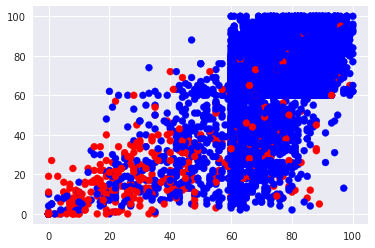

In [5]:
#plot eixo y media do primeiro ano, eixo x media do segundo. cores representando evasao ou nao
colors = ['red','blue']
plt.scatter(dados.loc[:, 'LnguaPortuguesaeLiteraturaI90H'], 
            dados.loc[:, 'MatemticaI120H'], 
            c=dados['classe'], 
            cmap=matplotlib.colors.ListedColormap(colors))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


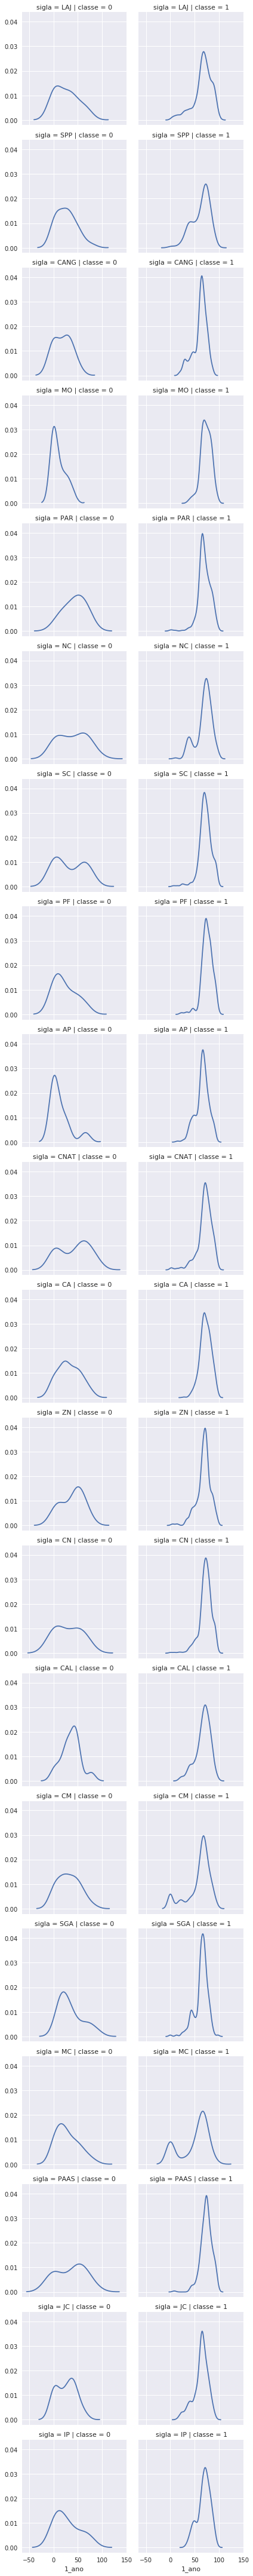

In [8]:
#TODO DA PARA FAZER UMA ANÁLISE EM RELAÇÃO AO QQ-PLOT

nota_1 = dados[['LnguaPortuguesaeLiteraturaI90H', 'MatemticaI120H']].mean(axis=1)
dados['1_ano'] = nota_1

g = sns.FacetGrid(dados, col="classe",  row="sigla")
g = g.map(sns.kdeplot, "1_ano")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


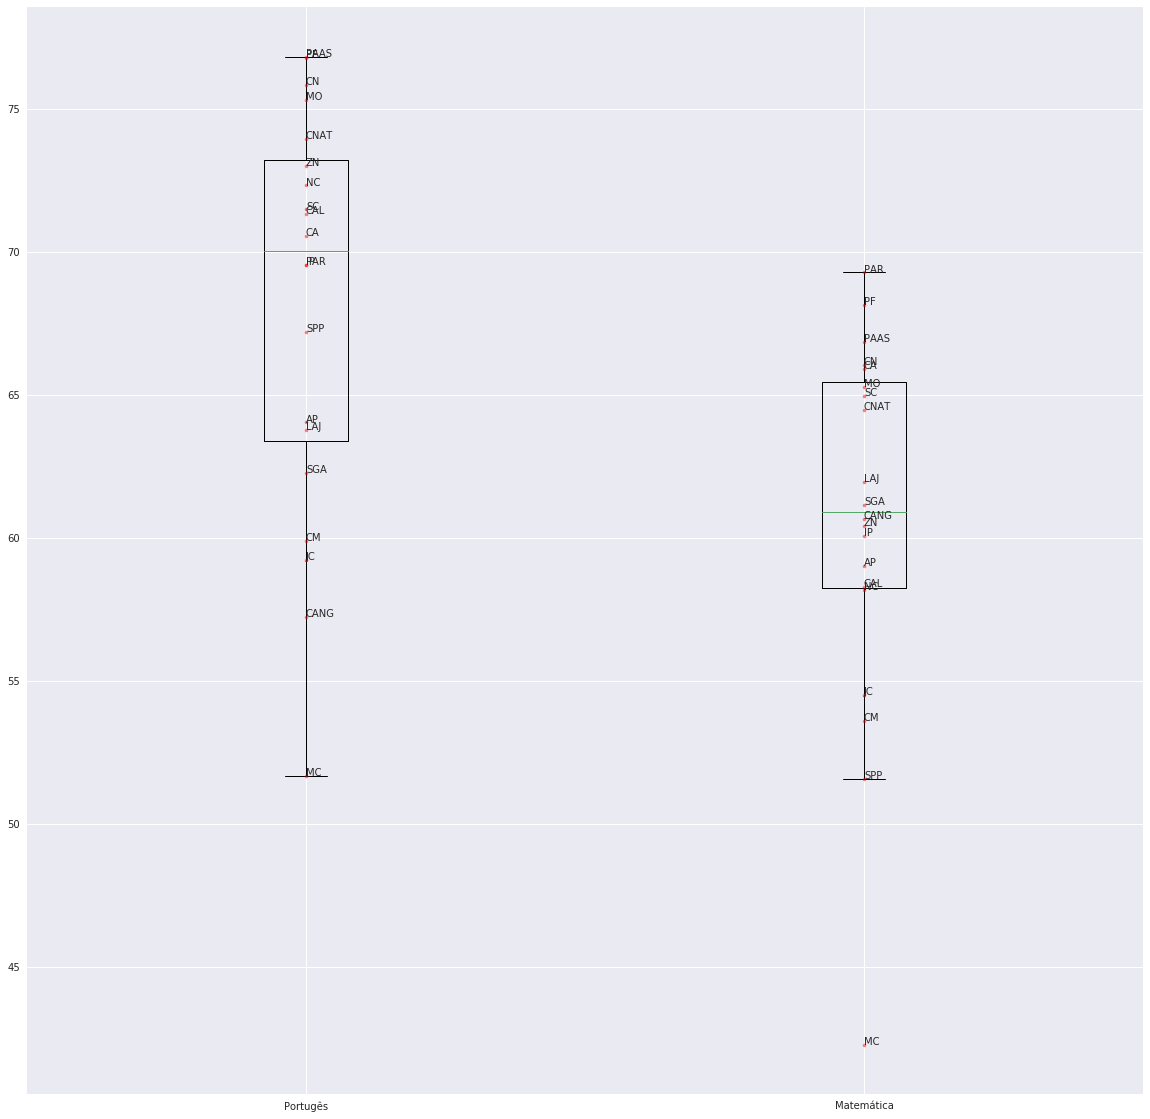

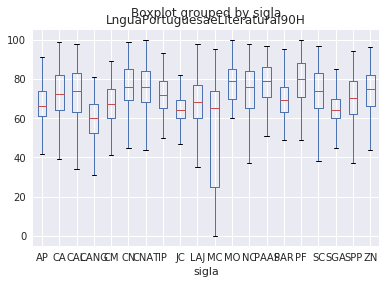

In [11]:
data_plot = [dados.groupby('sigla')['LnguaPortuguesaeLiteraturaI90H'].mean(), dados.groupby('sigla')['MatemticaI120H'].mean()]

fig, ax = plt.subplots(figsize=(20, 20))
plt.boxplot(data_plot)
plt.plot([1, 2], [dados.groupby('sigla')['LnguaPortuguesaeLiteraturaI90H'].mean(), dados.groupby('sigla')['MatemticaI120H'].mean()], 'r.', alpha=0.5)
ax.set_xticklabels( ['Portugês', 'Matemática'] )

for i, txt in enumerate( dados.groupby('sigla')['LnguaPortuguesaeLiteraturaI90H'].mean().index ):
    ax.annotate( txt, (1, dados.groupby('sigla')['LnguaPortuguesaeLiteraturaI90H'].mean()[i]), fontsize=10)
    ax.annotate( txt, (2, dados.groupby('sigla')['MatemticaI120H'].mean()[i]) )


fig = plt.figure()
dados.boxplot(column='LnguaPortuguesaeLiteraturaI90H',by='sigla')

[0.9507042253521126, 0.9120135363790186, 0.9482758620689655, 0.9616613418530351, 0.9324618736383442, 0.9669603524229075, 0.9509433962264151, 0.9340974212034384, 0.889196675900277, 0.9031007751937985, 0.8787185354691076, 0.9635535307517085, 0.9132530120481928, 0.950530035335689, 0.9798657718120806, 0.9606986899563319, 0.910941475826972, 0.9601990049751243, 0.9064935064935065, 0.9432624113475178]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


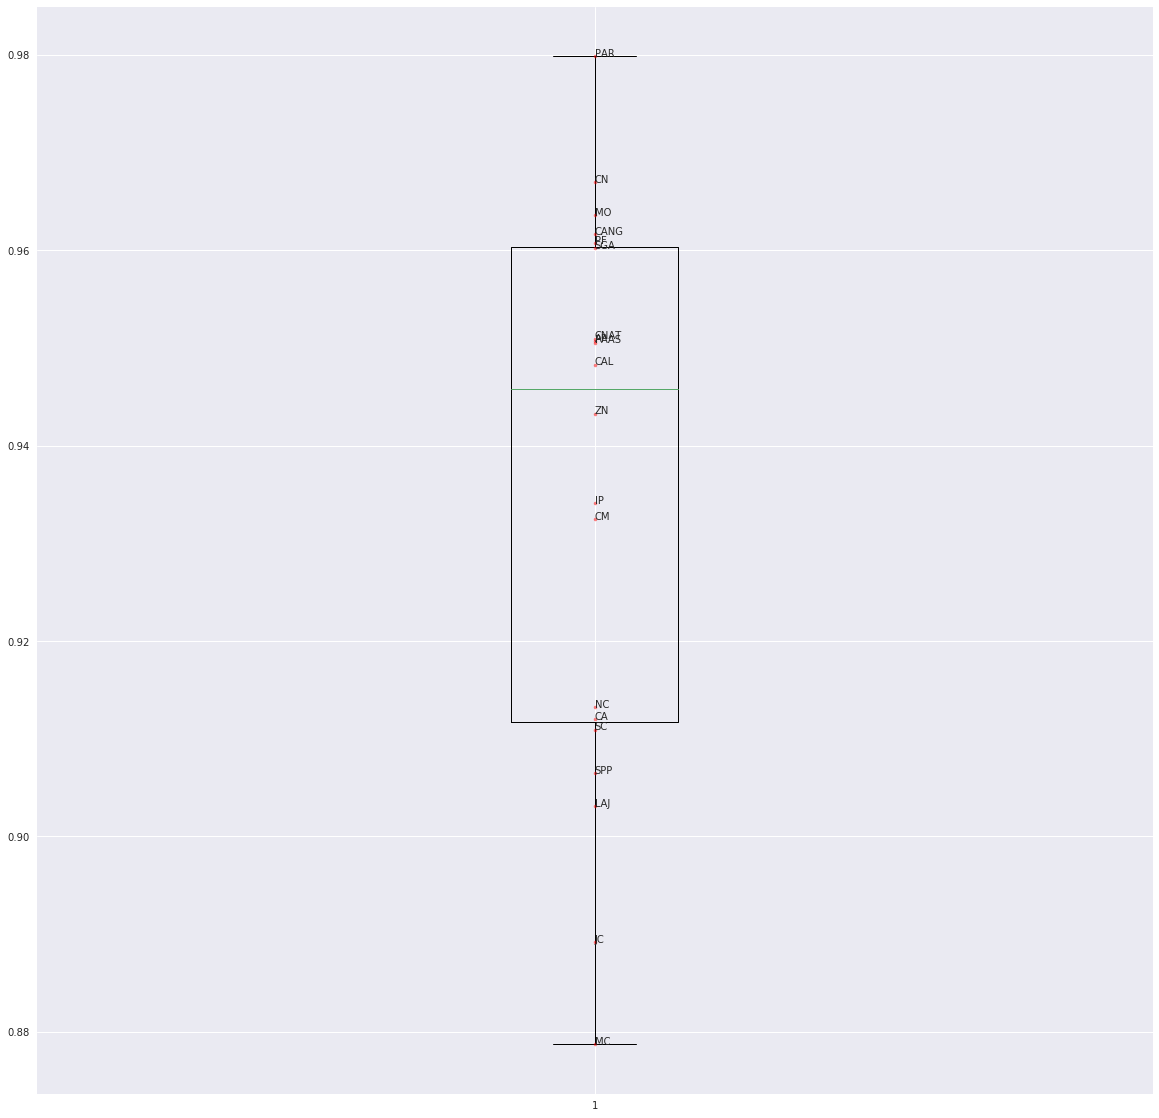

In [12]:
data_plot = []
ind = []

for index1, group1 in dados.groupby(['sigla']):    
    
    qnt_alunos = dados[dados.sigla == index1]['sigla'].count()
    qnt_evasao = dados[(dados.sigla == index1) & (dados.classe == 0)]['sigla'].count()
    tx_evasao  = 1 - qnt_evasao/qnt_alunos
    
    ind.append(index1)
    data_plot.append(tx_evasao)
    
print(data_plot)

fig, ax = plt.subplots(figsize=(20, 20))
plt.boxplot(data_plot)
#plt.plot([1], data_plot, 'r.', alpha=0.5)
plt.plot(np.ones(len(data_plot)), data_plot, 'r.', alpha=0.5)

for i, txt in enumerate( ind ):
    ax.annotate( txt, (1, data_plot[i]), fontsize=10)

# Análise em mapas

In [13]:
sumario_campus = pd.DataFrame()
sumario_campus['LAT'] = ind
sumario_campus['LNG'] = ind
sumario_campus['NOME'] = ind
sumario_campus['tx_evasao'] = data_plot
sumario_campus.index = ind

sumario_campus.loc['AP','LAT'] = -5.626647
sumario_campus.loc['AP','LNG'] = -37.8079408
sumario_campus.loc['AP','NOME'] = 'Apodi'

sumario_campus.loc['CA','LAT'] = -6.4455399
sumario_campus.loc['CA','LNG'] = -37.0690543
sumario_campus.loc['CA','NOME'] = 'Caicó'

sumario_campus.loc['CAL','LAT'] = -5.7882761
sumario_campus.loc['CAL','LNG'] = -35.207484
sumario_campus.loc['CAL','NOME'] = 'Cidade Alta'

sumario_campus.loc['CANG','LAT'] = -6.356481
sumario_campus.loc['CANG','LNG'] = -35.16137
sumario_campus.loc['CANG','NOME'] = 'Canguaretama'

sumario_campus.loc['CM','LAT'] = -5.6526002
sumario_campus.loc['CM','LNG'] = -35.4289211
sumario_campus.loc['CM','NOME'] = 'Ceará-Mirim'

sumario_campus.loc['CN','LAT'] = -6.2522742
sumario_campus.loc['CN','LNG'] = -36.5355755
sumario_campus.loc['CN','NOME'] = 'Currais Novos'

sumario_campus.loc['CNAT','LAT'] = -5.8116998
sumario_campus.loc['CNAT','LNG'] = -35.2032445
sumario_campus.loc['CNAT','NOME'] = 'Natal'

sumario_campus.loc['IP','LAT'] = -5.535475
sumario_campus.loc['IP','LNG'] = -36.870884
sumario_campus.loc['IP','NOME'] = 'Ipanguaçu'

sumario_campus.loc['JC','LAT'] = -5.5445745
sumario_campus.loc['JC','LNG'] = -35.7977312
sumario_campus.loc['JC','NOME'] = 'João Câmara'

sumario_campus.loc['LAJ','LAT'] = -5.7045319
sumario_campus.loc['LAJ','LNG'] = -36.2354056
sumario_campus.loc['LAJ','NOME'] = 'Lajes'

sumario_campus.loc['MC','LAT'] = -5.1519506
sumario_campus.loc['MC','LNG'] = -36.5749401
sumario_campus.loc['MC','NOME'] = 'Macau'

sumario_campus.loc['MO','LAT'] = -5.2137844
sumario_campus.loc['MO','LNG'] = -37.3193046
sumario_campus.loc['MO','NOME'] = 'Mossoró'

sumario_campus.loc['NC','LAT'] = -6.4705831
sumario_campus.loc['NC','LNG'] = -35.4449409
sumario_campus.loc['NC','NOME'] = 'Nova Cruz'

sumario_campus.loc['PAAS','LAT'] = -6.6996818
sumario_campus.loc['PAAS','LNG'] = -36.6674975
sumario_campus.loc['PAAS','NOME'] = 'Parelhas'

sumario_campus.loc['PAR','LAT'] = -5.938754
sumario_campus.loc['PAR','LNG'] = -35.2664888
sumario_campus.loc['PAR','NOME'] = 'Parnamirim'

sumario_campus.loc['PF','LAT'] = -6.1457562
sumario_campus.loc['PF','LNG'] = -38.2037518
sumario_campus.loc['PF','NOME'] = 'Pau dos Ferros'

sumario_campus.loc['SC','LAT'] = -6.2278238
sumario_campus.loc['SC','LNG'] = -36.0270737
sumario_campus.loc['SC','NOME'] = 'Santa Cruz'

sumario_campus.loc['SGA','LAT'] = -5.7242691
sumario_campus.loc['SGA','LNG'] = -35.2404887
sumario_campus.loc['SGA','NOME'] = 'São Gonçalo do Amarante'

sumario_campus.loc['SPP','LAT'] = -5.8954807
sumario_campus.loc['SPP','LNG'] = -35.7544978
sumario_campus.loc['SPP','NOME'] = 'São Paulo do Potengi'

sumario_campus.loc['ZN','LAT'] = -5.7491553
sumario_campus.loc['ZN','LNG'] = -35.2602211
sumario_campus.loc['ZN','NOME'] = 'Zona norte'

sumario_campus

LAT      LNG                     NOME  tx_evasao
AP   -5.62665 -37.8079                    Apodi   0.950704
CA   -6.44554 -37.0691                    Caicó   0.912014
CAL  -5.78828 -35.2075              Cidade Alta   0.948276
CANG -6.35648 -35.1614             Canguaretama   0.961661
CM    -5.6526 -35.4289              Ceará-Mirim   0.932462
CN   -6.25227 -36.5356            Currais Novos   0.966960
CNAT  -5.8117 -35.2032                    Natal   0.950943
IP   -5.53547 -36.8709                Ipanguaçu   0.934097
JC   -5.54457 -35.7977              João Câmara   0.889197
LAJ  -5.70453 -36.2354                    Lajes   0.903101
MC   -5.15195 -36.5749                    Macau   0.878719
MO   -5.21378 -37.3193                  Mossoró   0.963554
NC   -6.47058 -35.4449                Nova Cruz   0.913253
PAAS -6.69968 -36.6675                 Parelhas   0.950530
PAR  -5.93875 -35.2665               Parnamirim   0.979866
PF   -6.14576 -38.2038           Pau dos Ferros   0.960699
SC   -6.22782 -36.0271               Santa Cruz   0.910941
SGA  -5.72427 -35.2405  São Gonçalo do Amarante   0.960199
SPP  -5.89548 -35.7545     São Paulo do Potengi   0.906494
ZN   -5.74916 -35.2602               Zona norte   0.943262

In [15]:
# Create a map object
m = folium.Map(
    location=[-5.817691, -36.445725],
    zoom_start=8,
    tiles='Stamen Terrain'
)

# Dictionary for colors
unit_type_colors = {
    1: 'green',
    0: 'red',
}

# Dictionary for icons
unit_type_icons = {
    'Elem': 'graduation-cap',
    'KGAR': 'odnoklassniki',
}

In [18]:
# Ploting the educational units on map

for index, row in sumario_campus.iterrows():
    folium.Marker([row['LAT'], row['LNG']],
                  icon=folium.Icon(
                          color = 'green',
                          #icon = 'graduation-cap',
                          prefix='fa'),
                  popup = index
        ).add_to(m)

# Add fullscreen button
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)

m

In [21]:
# load the data and use 'latin-1'encoding because the accent
geo_json_data = json.load(open('geojson/geojs-24-mun.json',encoding='latin-1'))

cities = []
# list all cities in the state
for city in geo_json_data['features']:
        cities.append(city['properties']['description'])
#cities

colormap = linear.YlGn.scale(
    sumario_campus.tx_evasao.min(),
    sumario_campus.tx_evasao.max())

sumario_campus['tx_evasao'] = 1 - sumario_campus['tx_evasao']

# Create a map object
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=7,
    tiles='Stamen Terrain'
)

# create a threshold of legend
threshold_scale = np.linspace(sumario_campus.tx_evasao.min(),
                              sumario_campus.tx_evasao.max(), 6, dtype=int).tolist()


for index, row in sumario_campus.iterrows():
    folium.Marker([row['LAT'], row['LNG']],
                  icon=folium.Icon(
                          color = 'green',
                          #icon = 'graduation-cap',
                          prefix='fa'),
                  popup = '({}, {})'.format(index, row['tx_evasao'])
        ).add_to(m)

m.choropleth(
    geo_data=geo_json_data,
    data=sumario_campus,
    columns=['NOME', 'tx_evasao'],
    key_on='feature.properties.description',
    fill_color='YlOrRd',
    legend_name='Taxa de Sucesso',
    highlight=True,
    #threshold_scale = threshold_scale
)

m

# Análise de correspondência

LnguaPortuguesaeLiteraturaI90H
------------------------------


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


LnguaPortuguesaeLiteraturaI90H_dependencia
------------------------------------------
LnguaPortuguesaeLiteraturaI90H_freq
-----------------------------------
MatemticaI120H
--------------


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


MatemticaI120H_dependencia
--------------------------
MatemticaI120H_freq
-------------------
acompanhamento
--------------
aluno_exclusivo_rede_publica
----------------------------
artificial
----------
conceito
--------
conceito_freq
-------------
descricao
---------
descricao_area_residencial
--------------------------
descricao_companhia_domiciliar
------------------------------
descricao_estado_civil
----------------------
descricao_historico
-------------------
descricao_imovel
----------------
descricao_mae_escolaridade
--------------------------
descricao_pai_escolaridade
--------------------------
descricao_raca
--------------
descricao_responsavel_escolaridade
----------------------------------
descricao_responsavel_financeiro
--------------------------------
descricao_trabalho
------------------
idade
-----
pessoa_fisica__sexo
-------------------
possui_necessidade_especial
---------------------------
qnt_pc
------
qnt_salarios
------------
qtd_pessoas_domicilio
------------

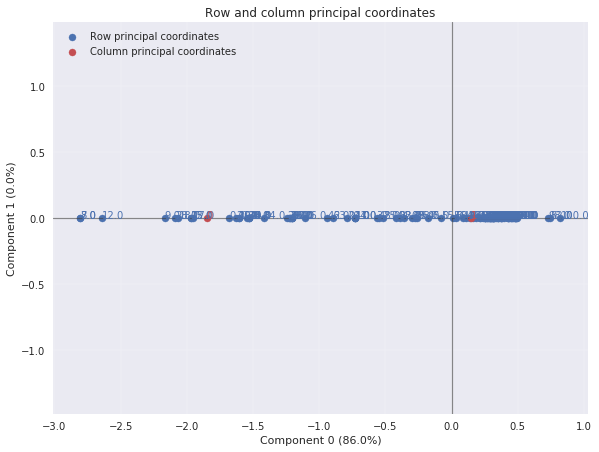

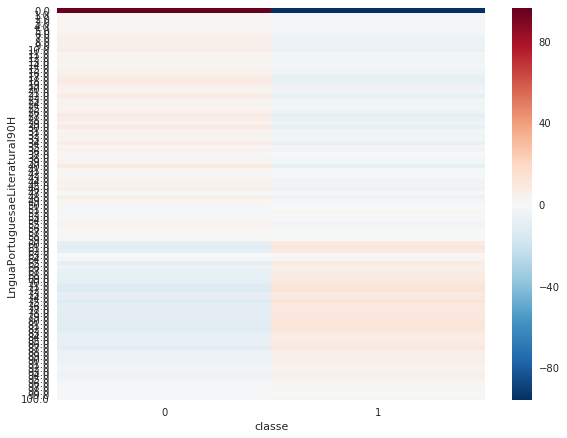

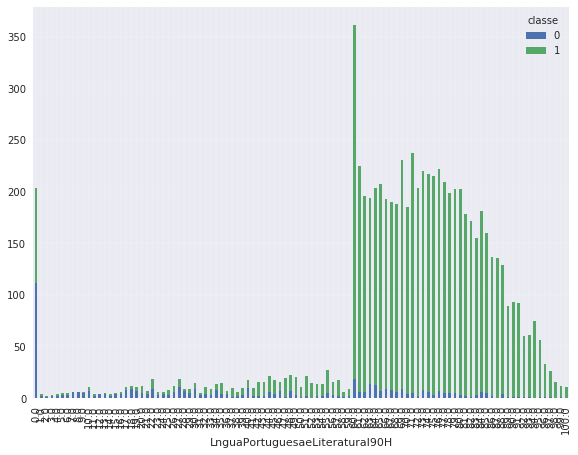

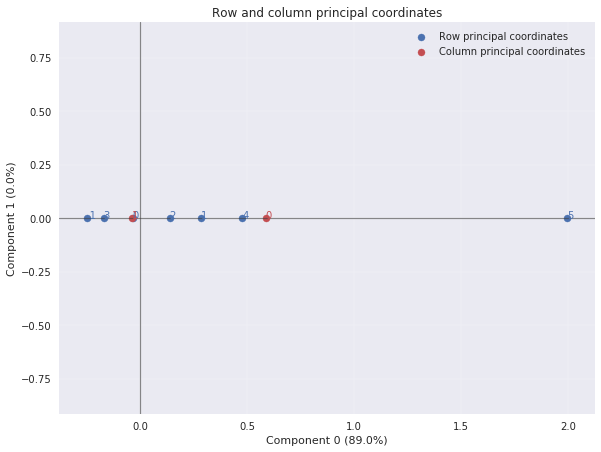

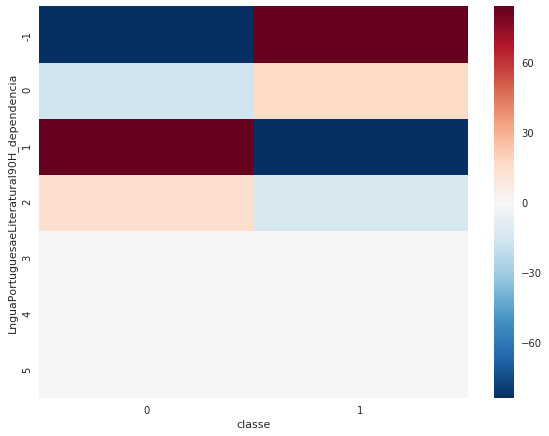

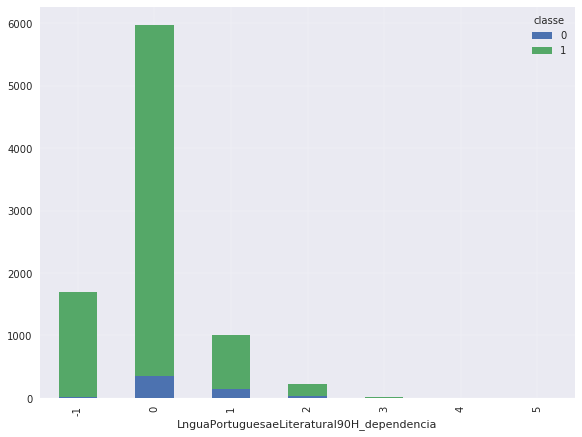

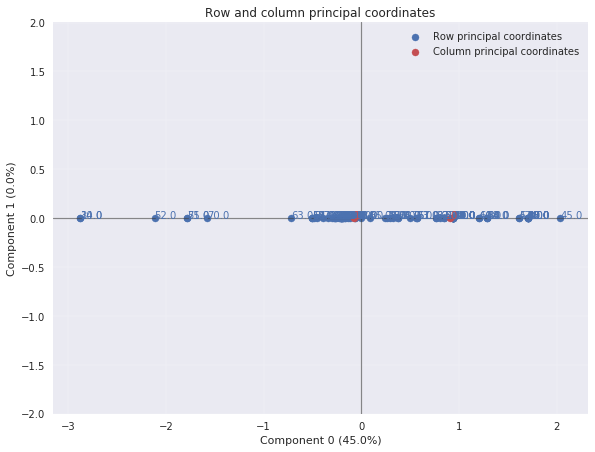

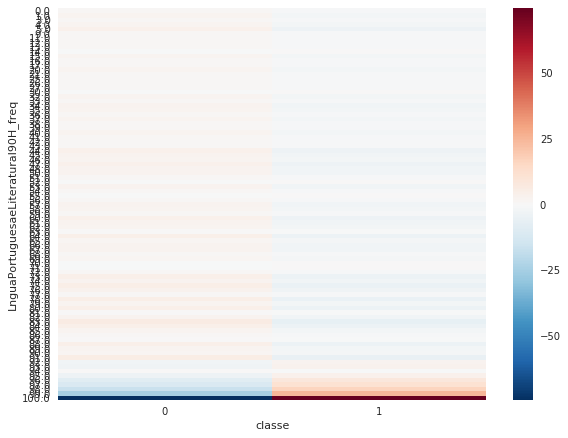

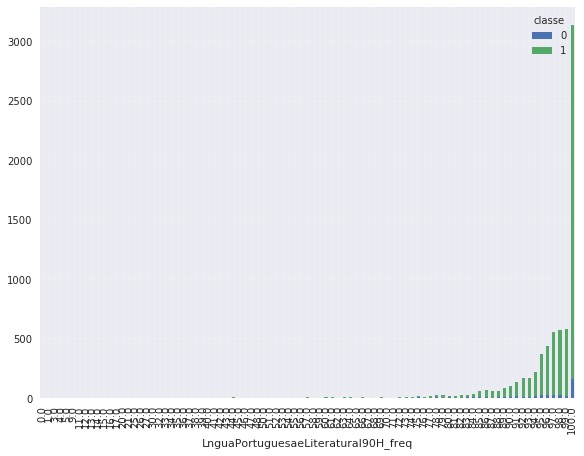

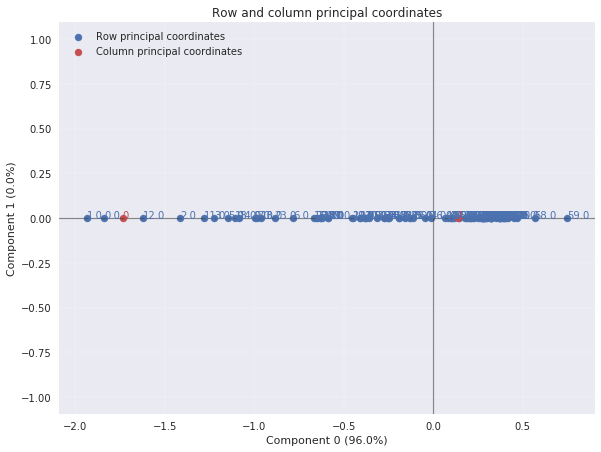

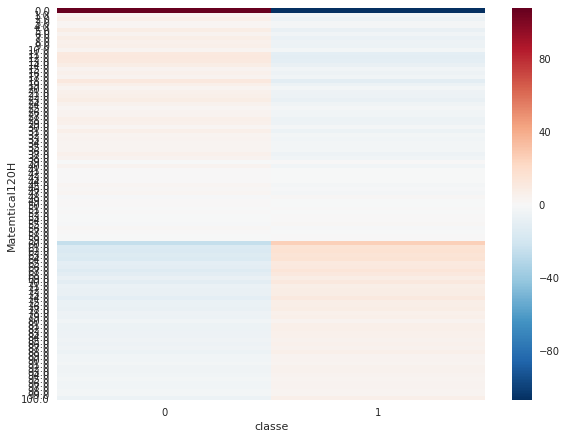

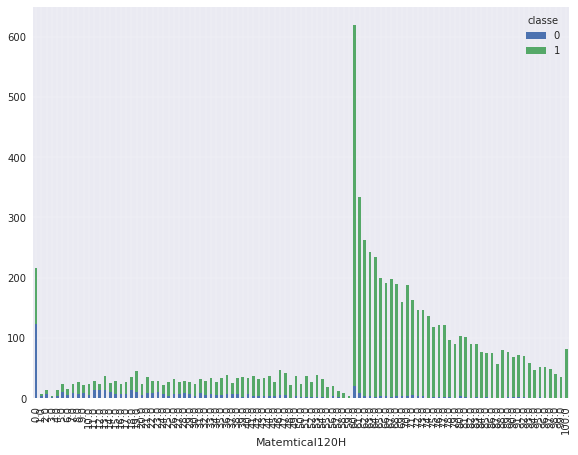

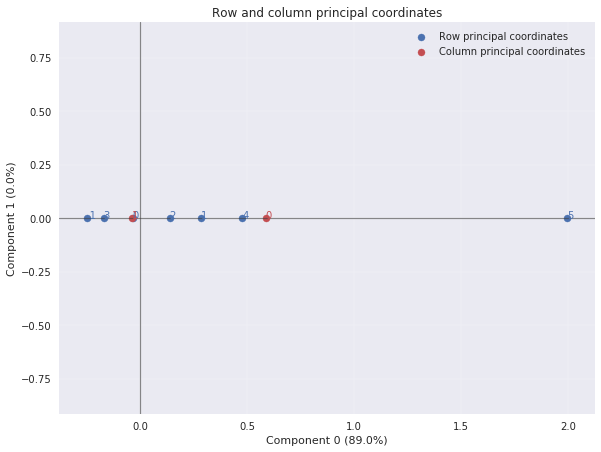

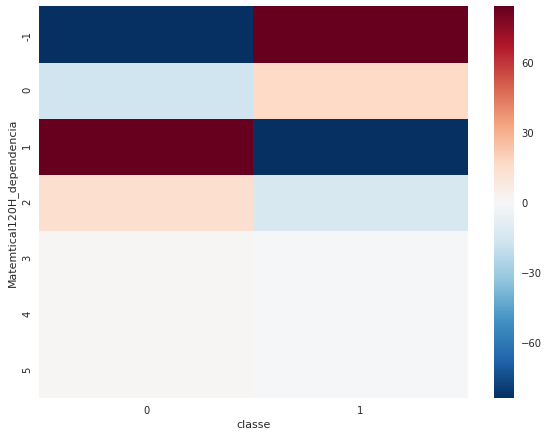

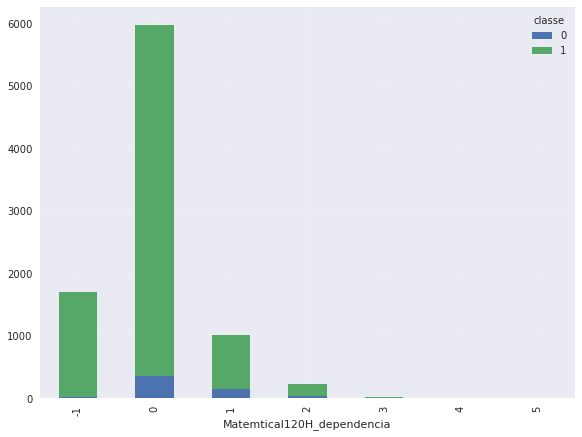

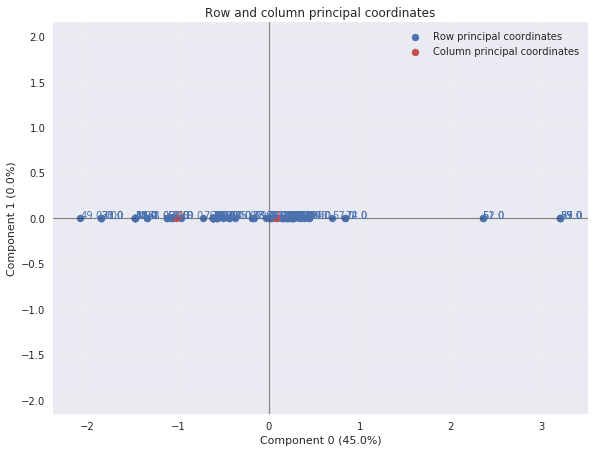

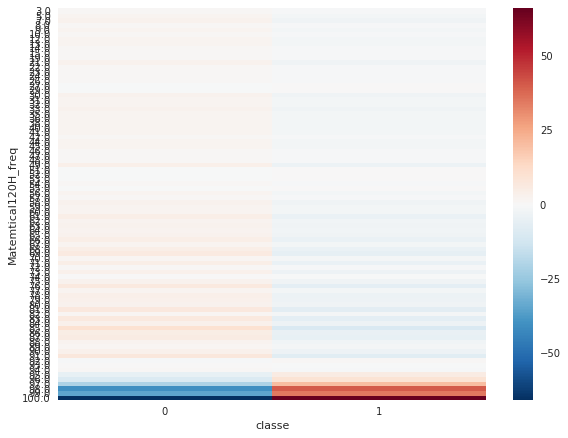

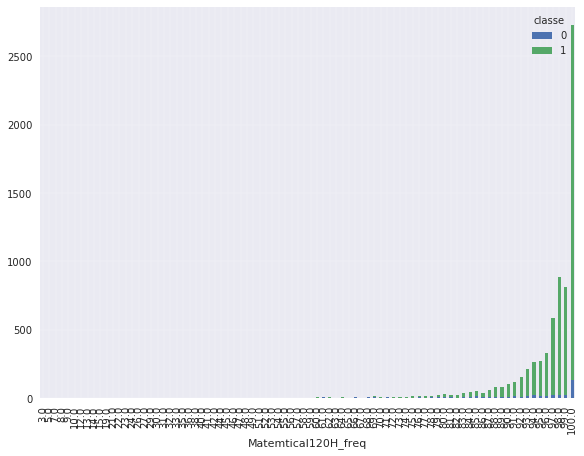

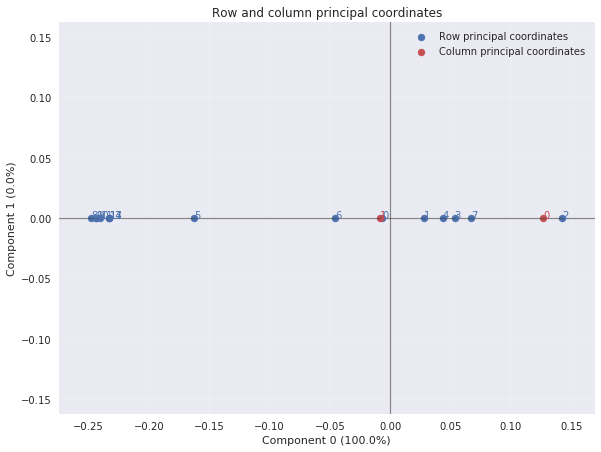

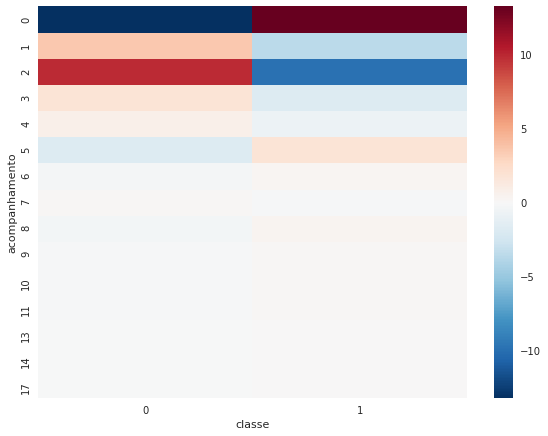

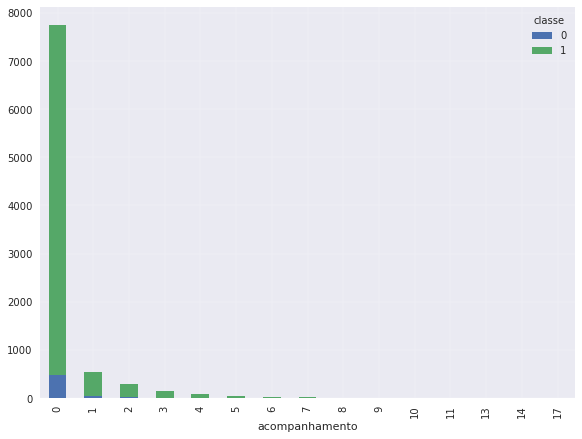

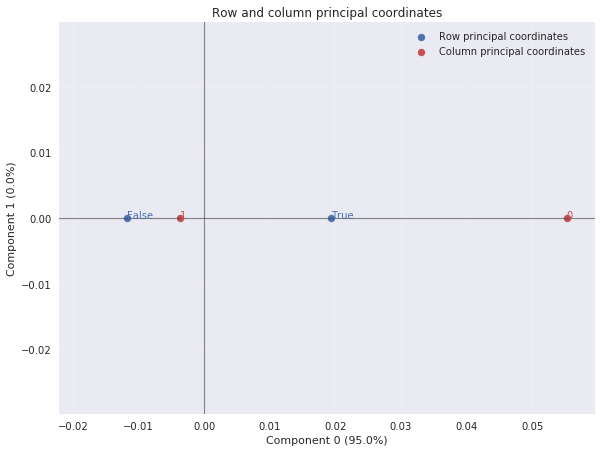

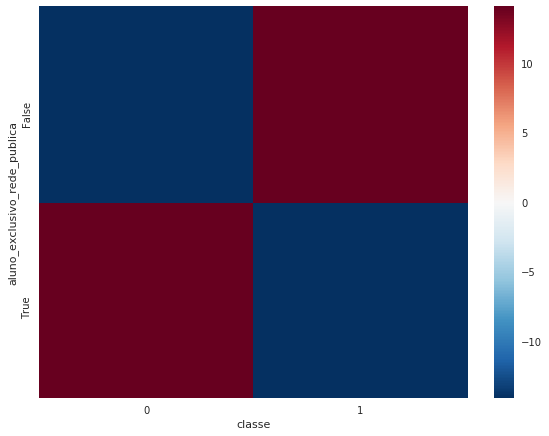

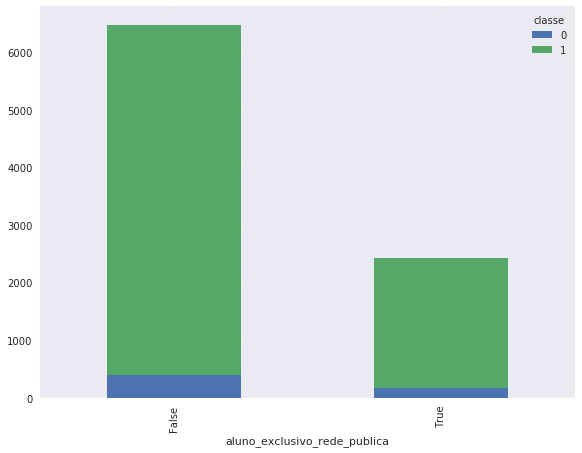

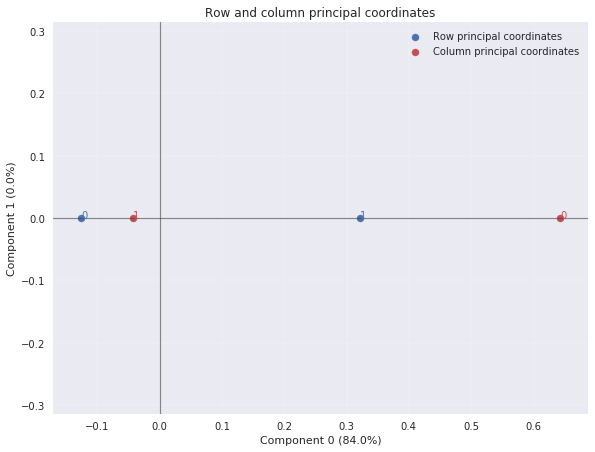

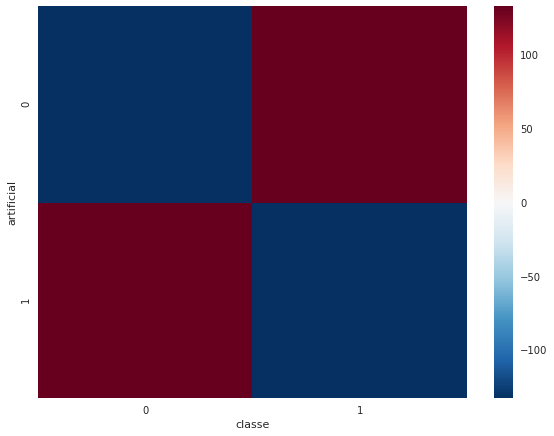

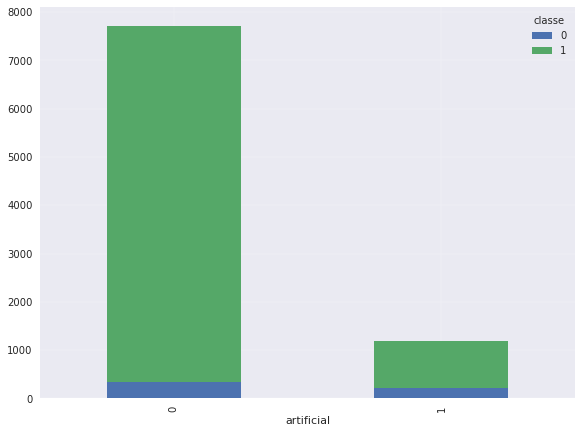

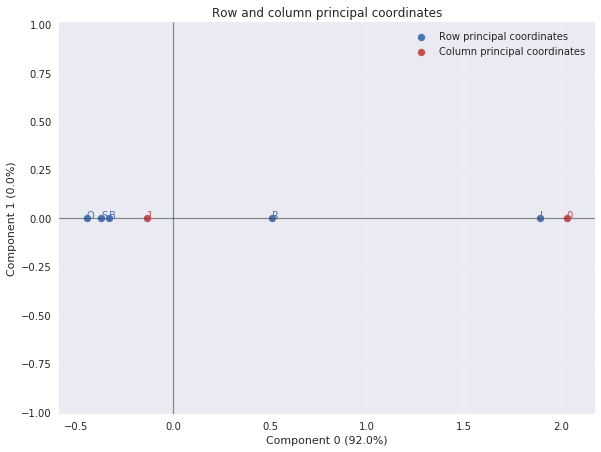

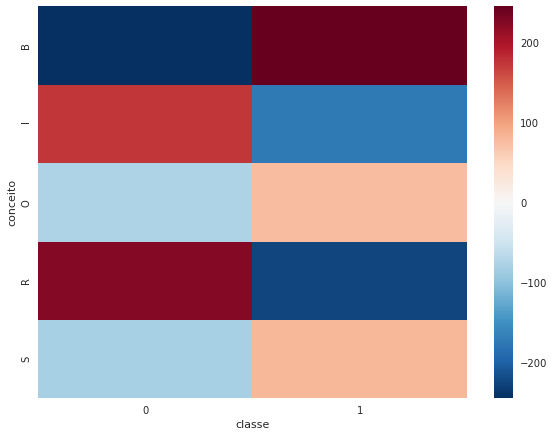

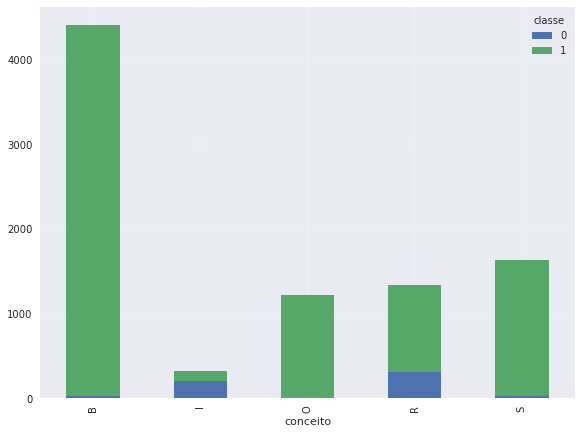

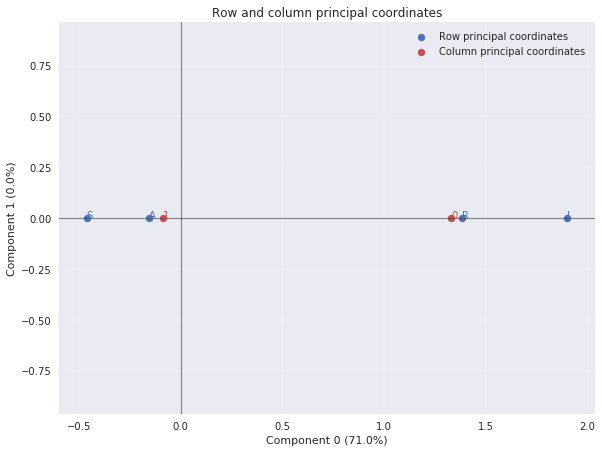

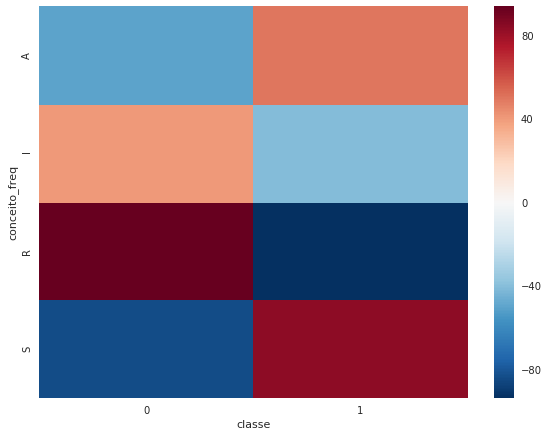

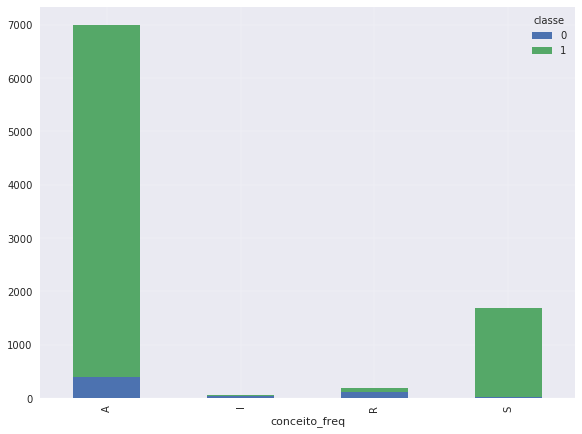

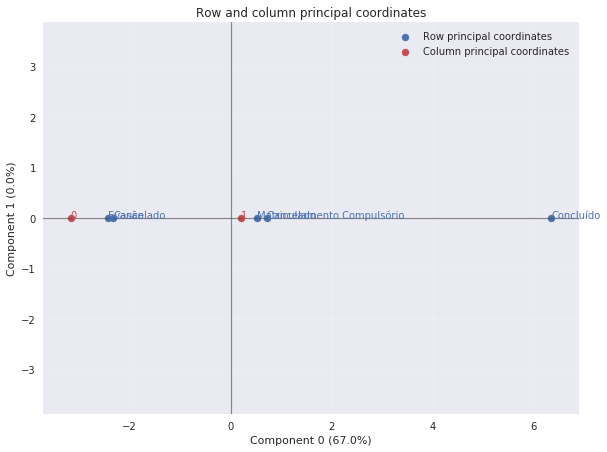

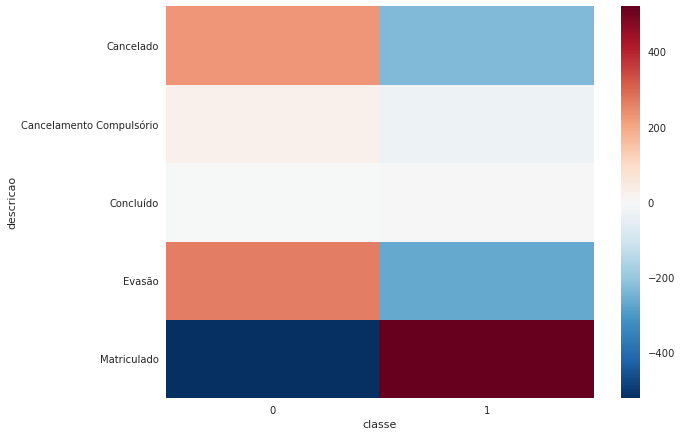

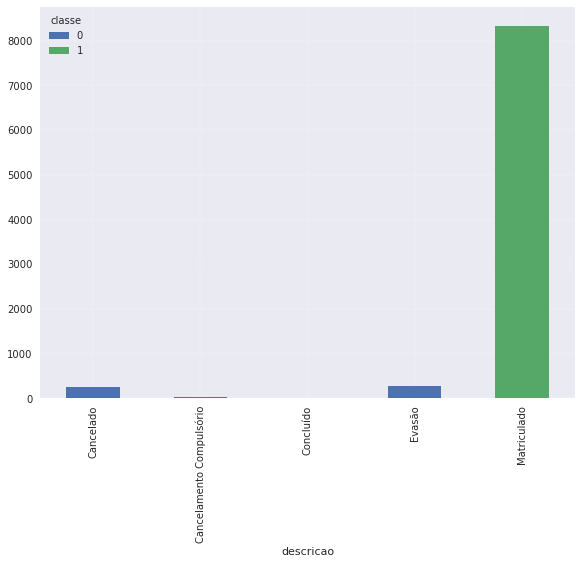

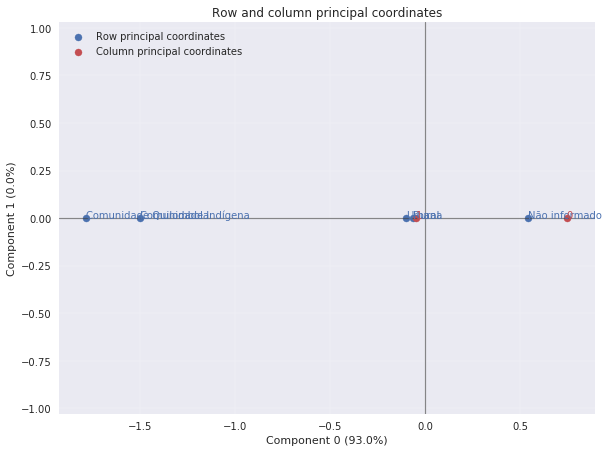

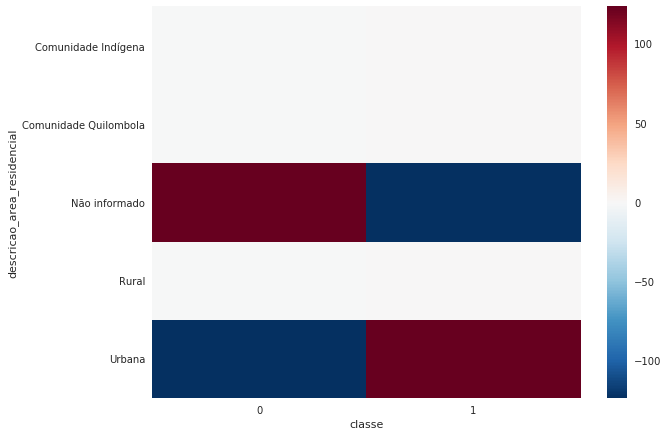

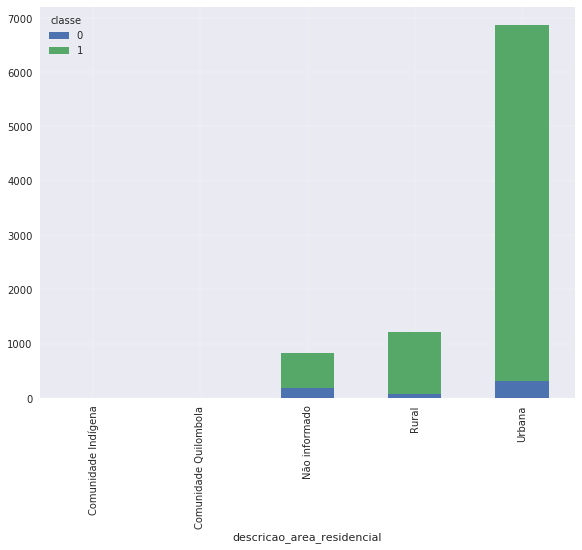

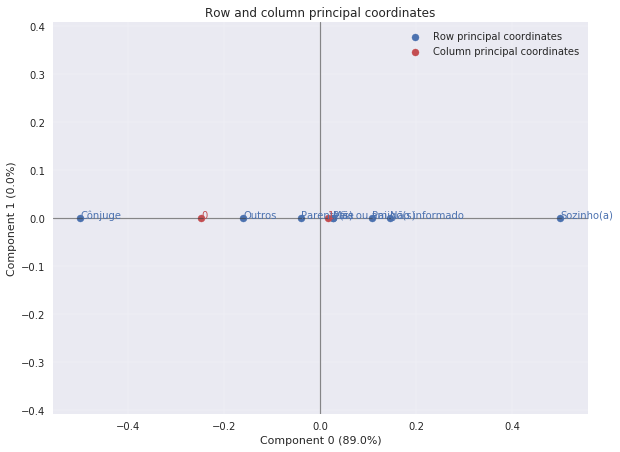

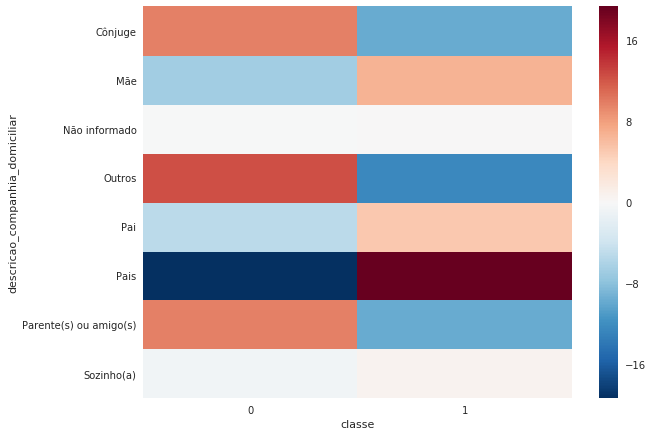

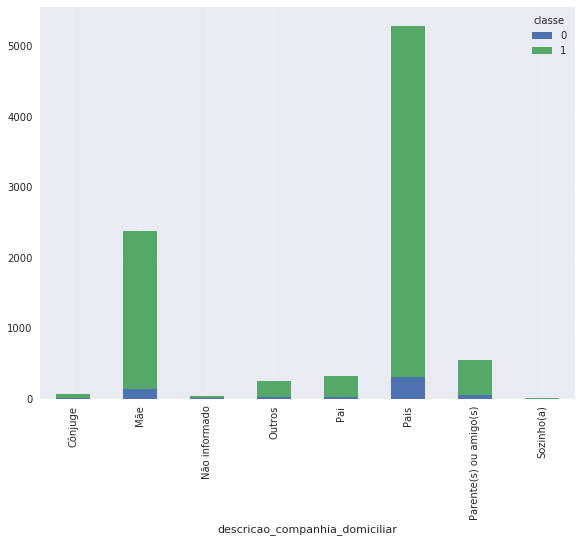

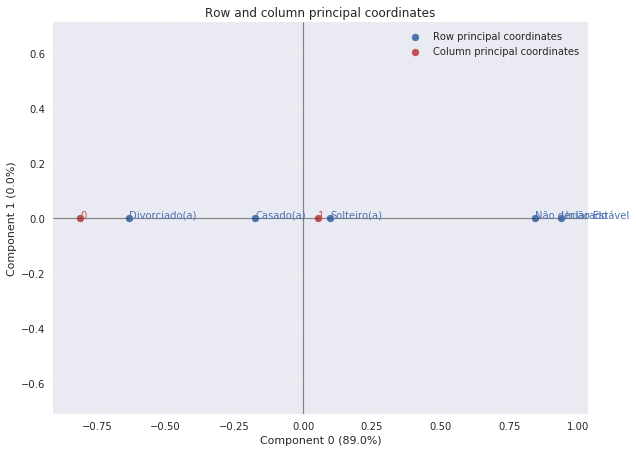

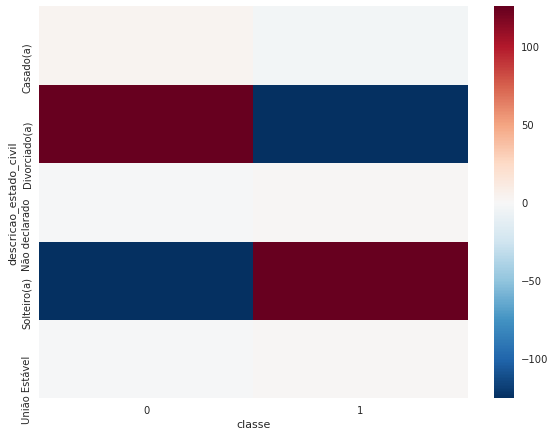

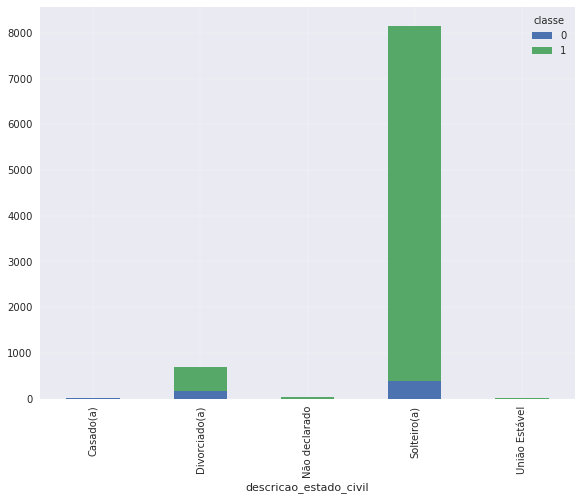

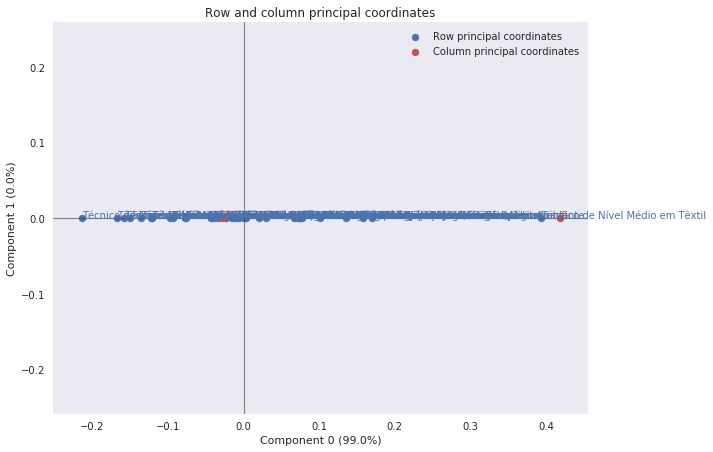

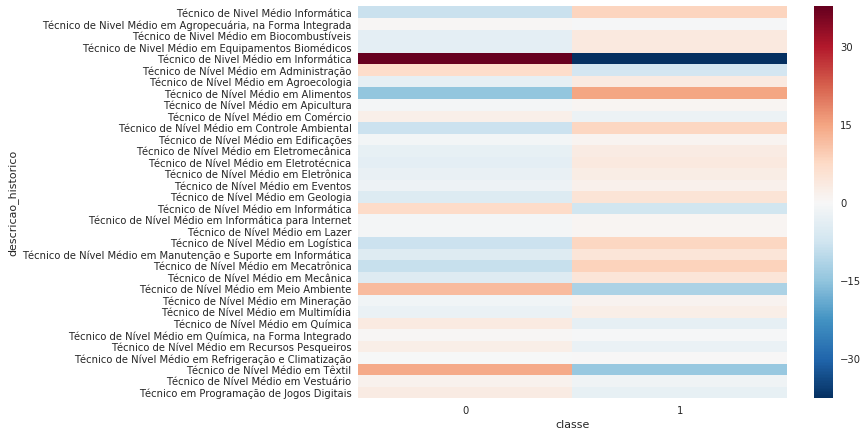

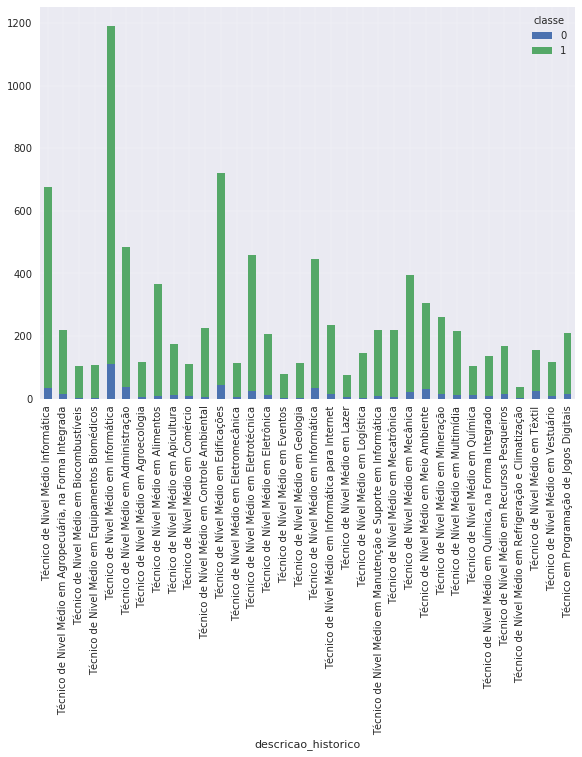

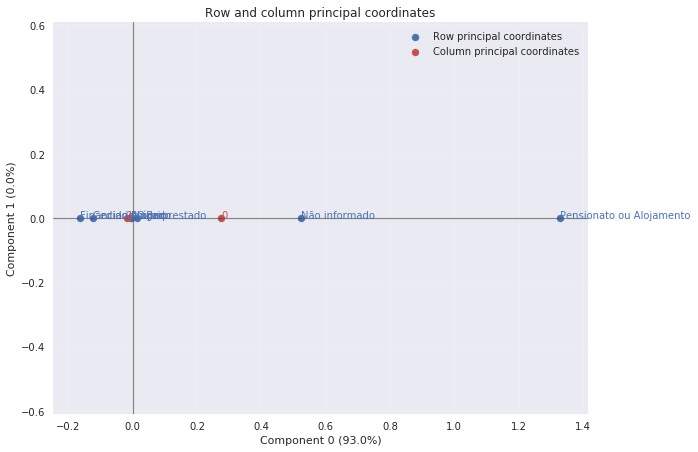

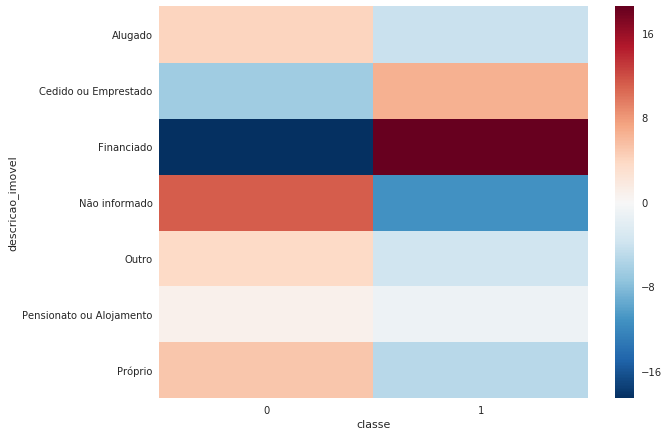

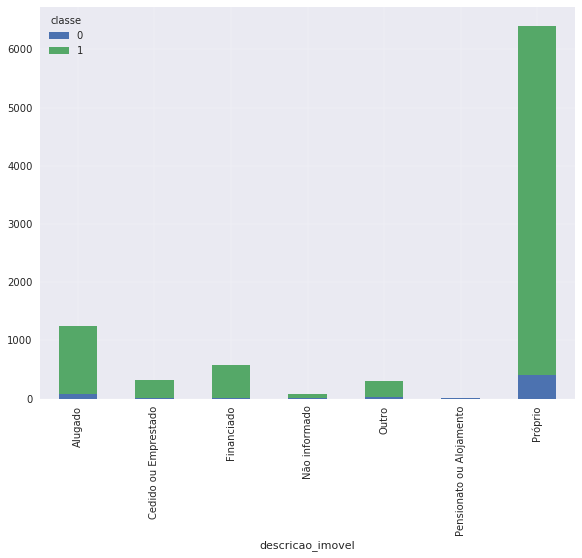

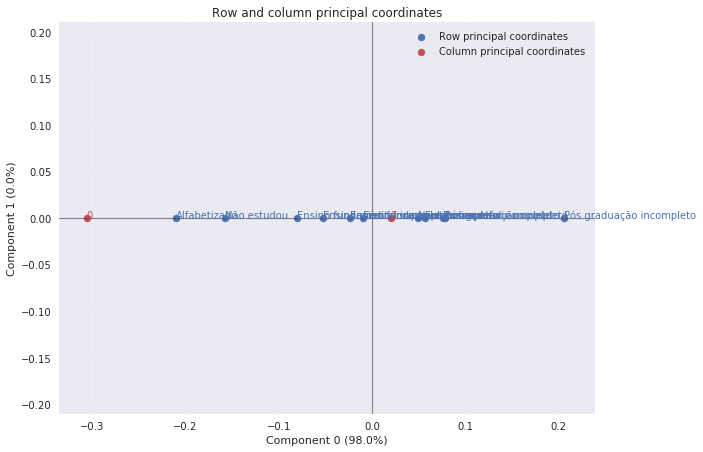

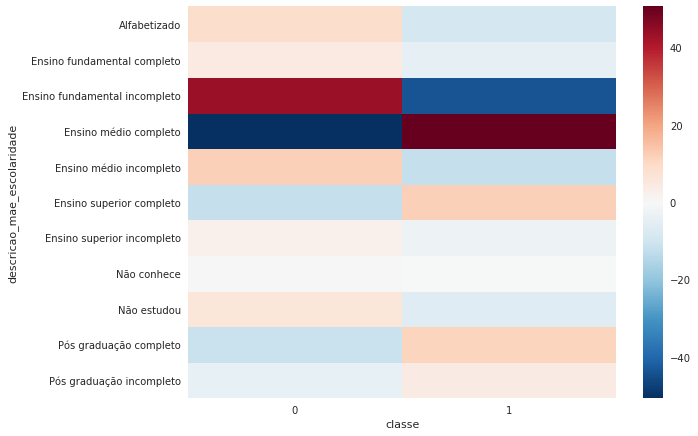

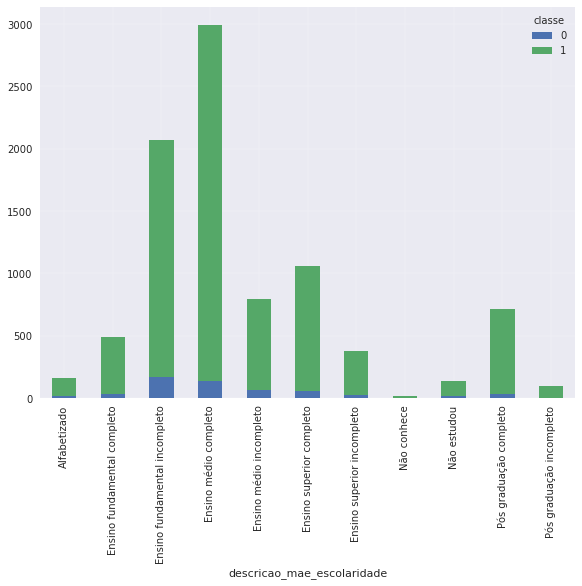

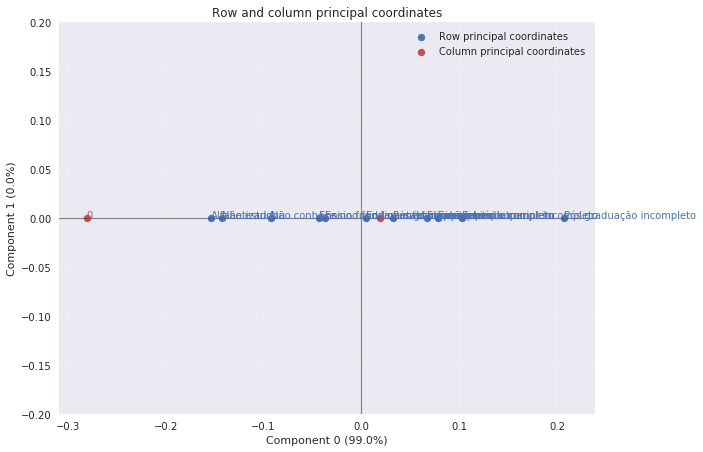

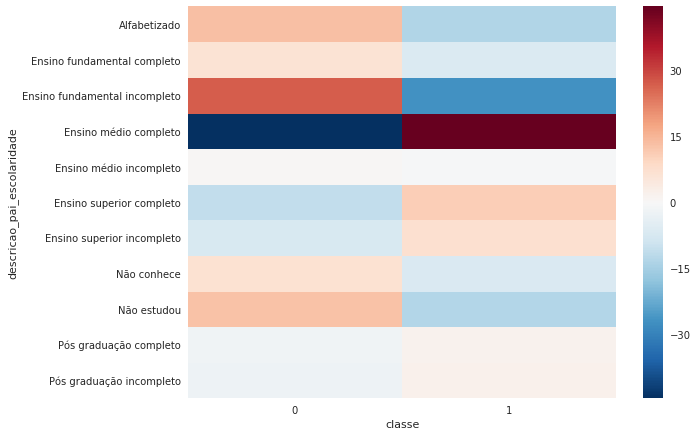

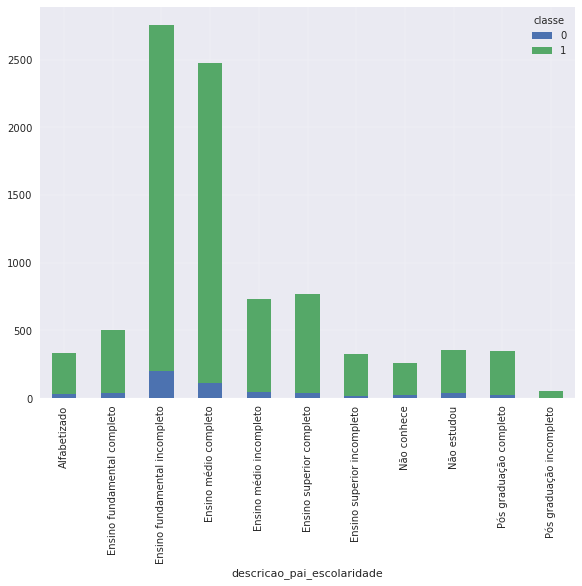

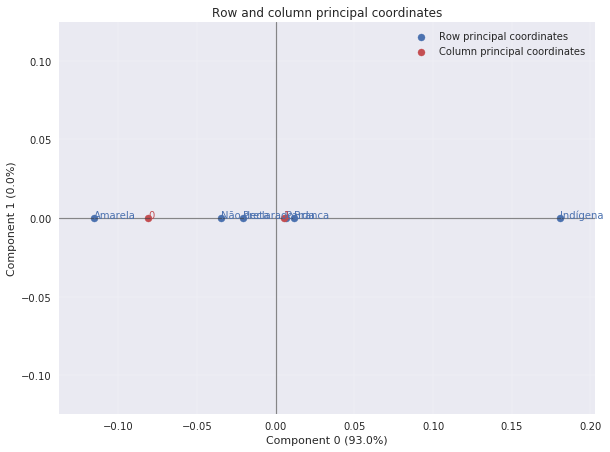

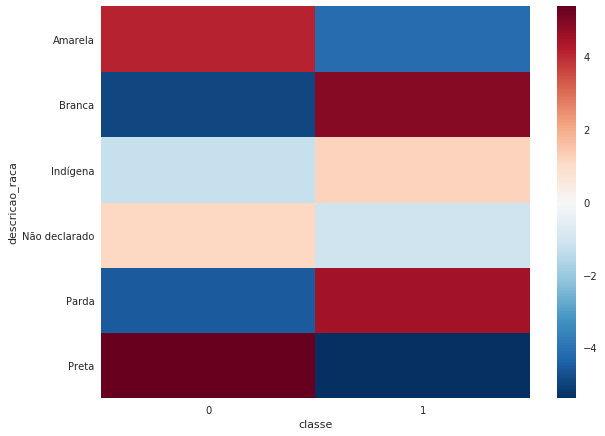

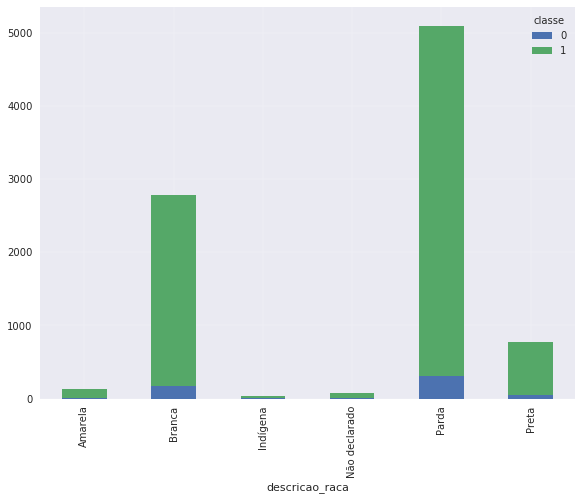

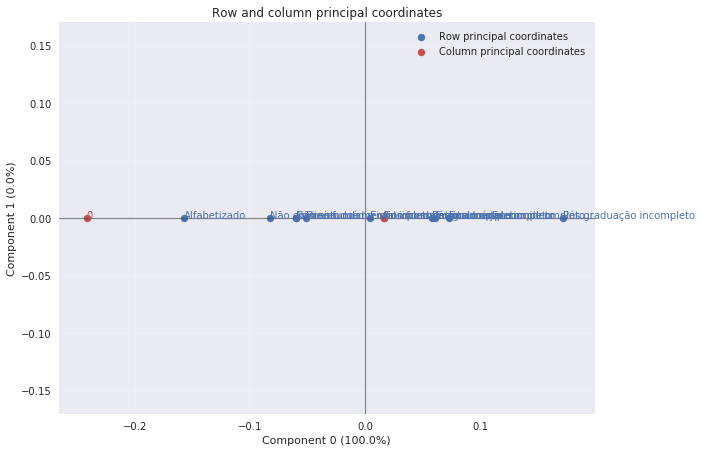

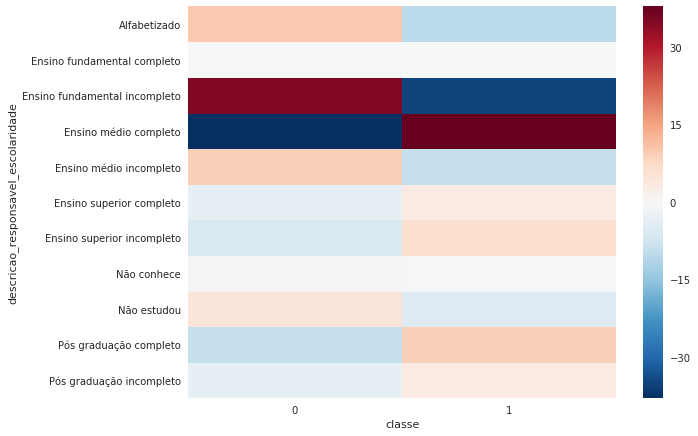

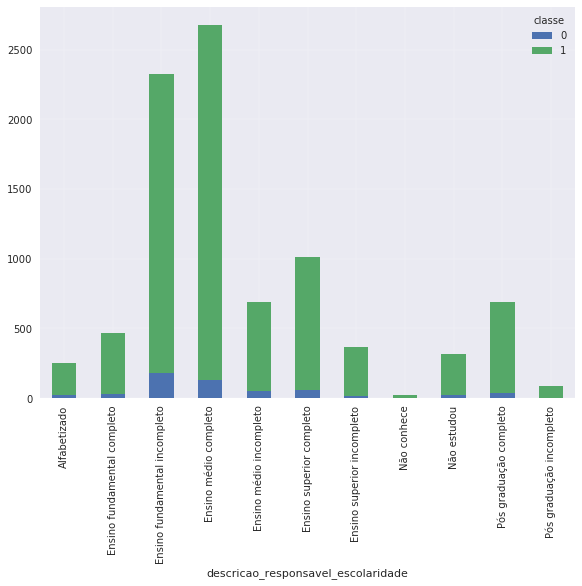

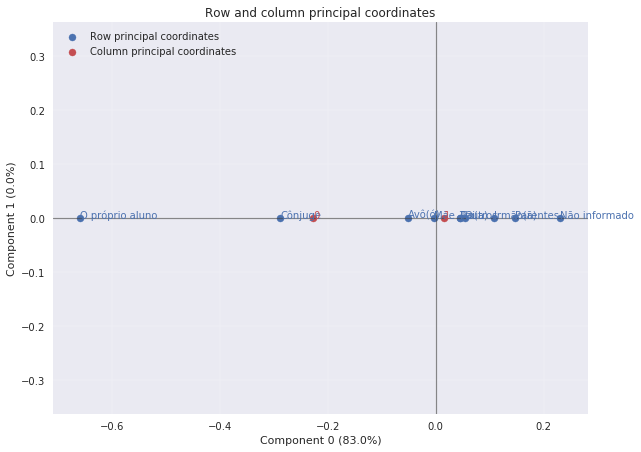

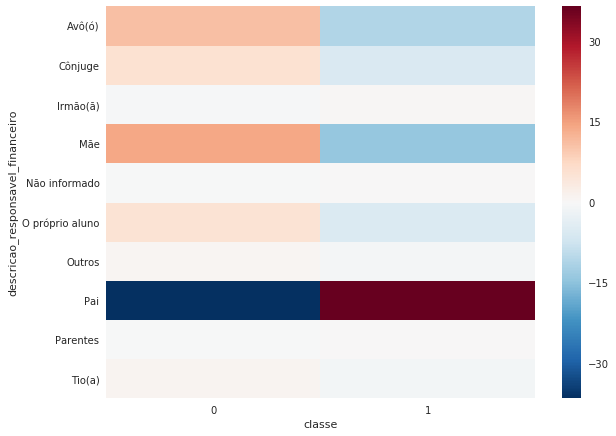

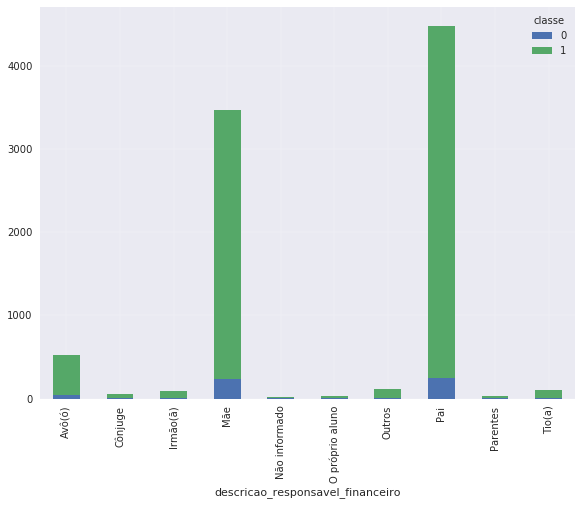

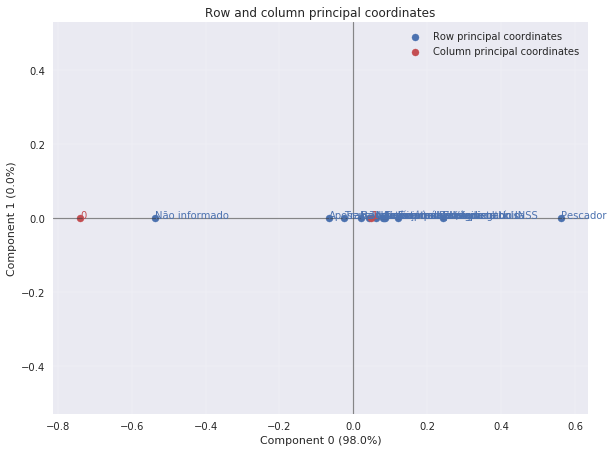

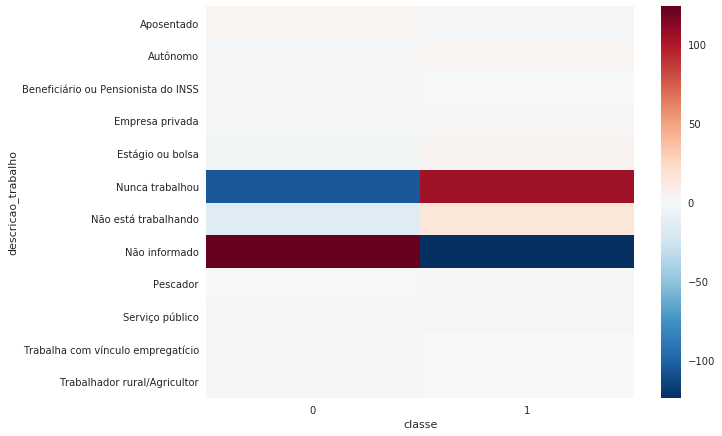

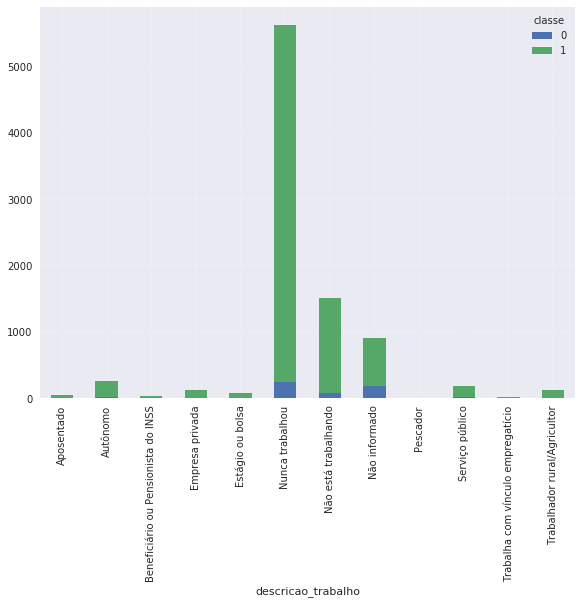

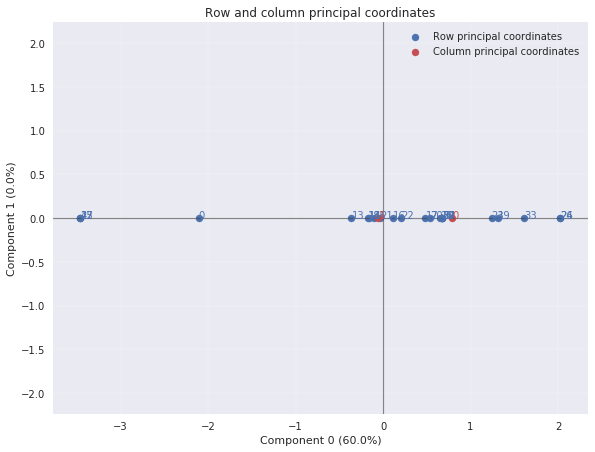

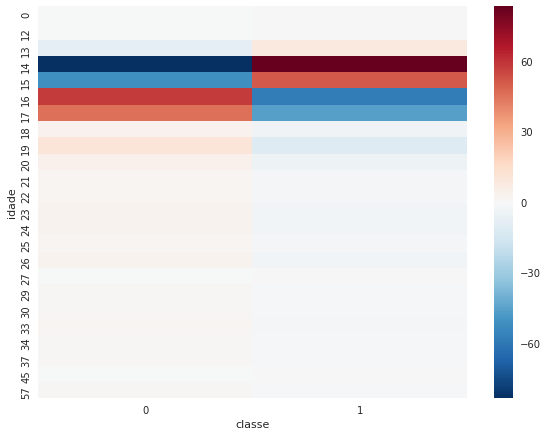

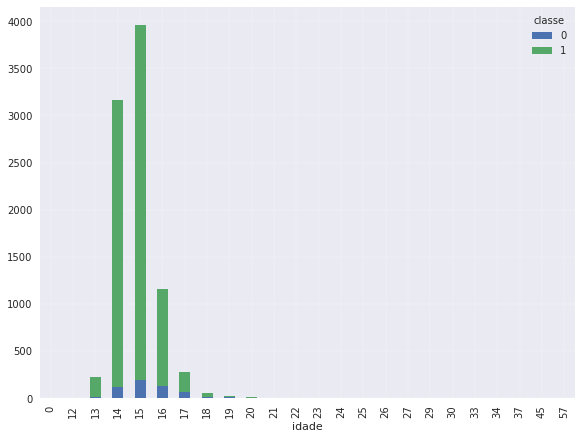

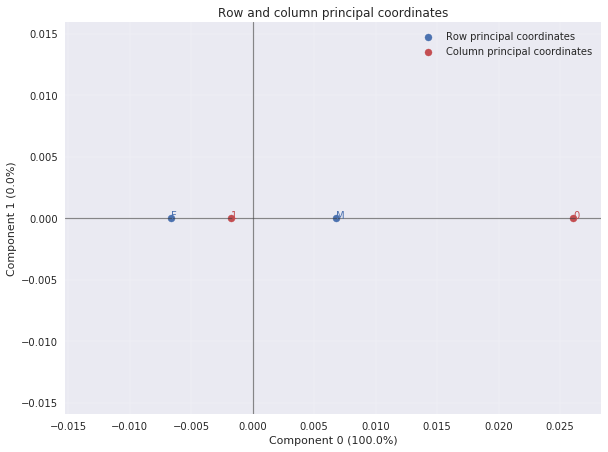

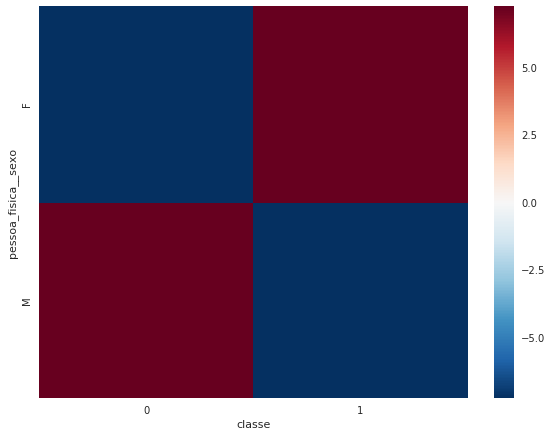

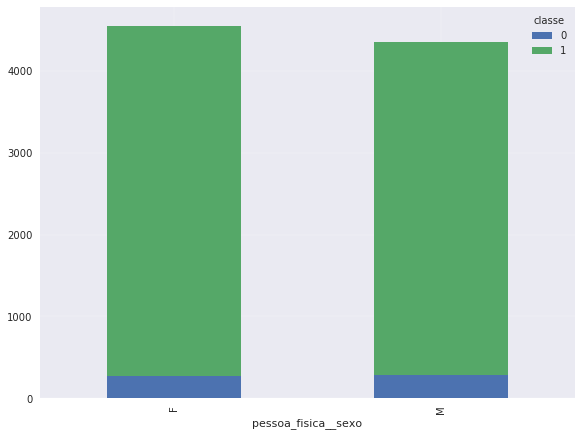

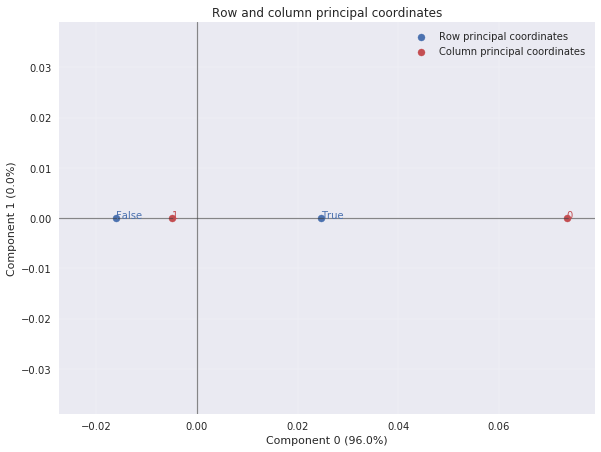

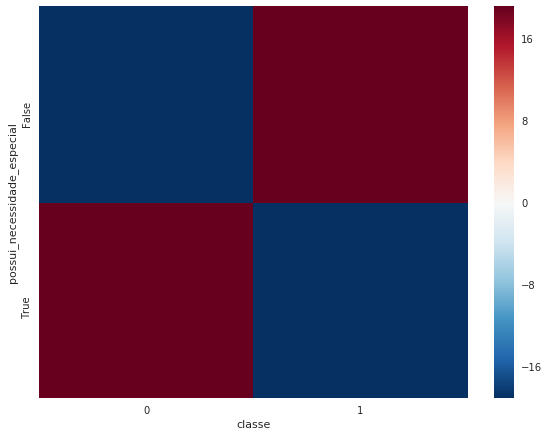

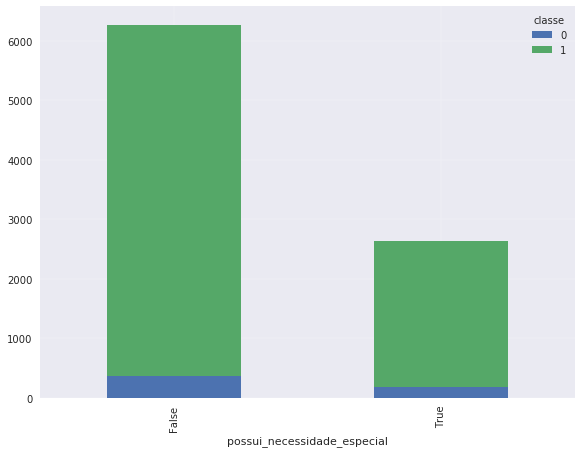

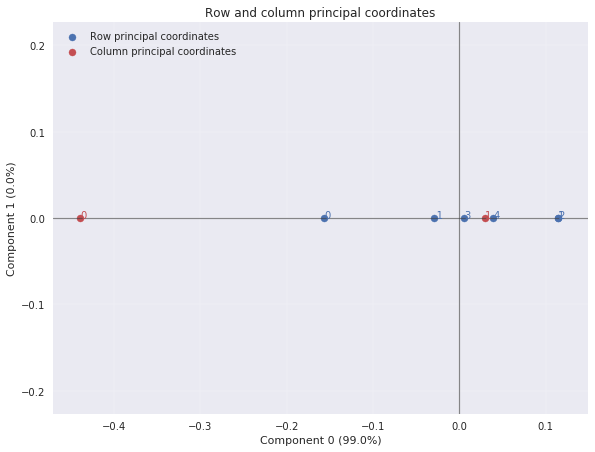

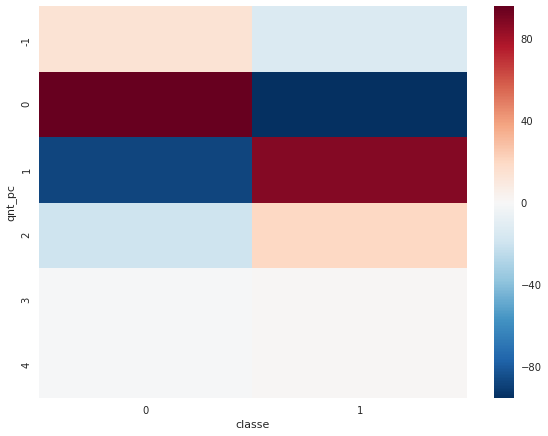

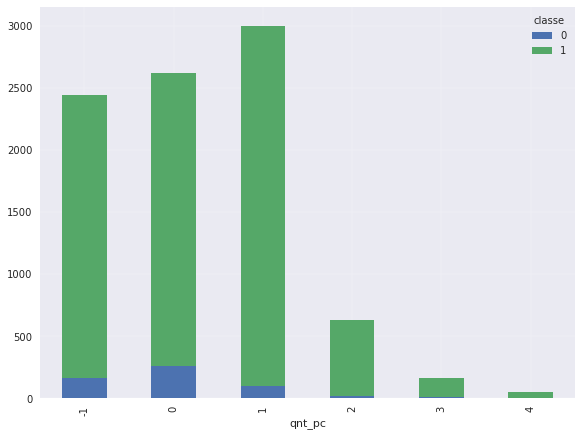

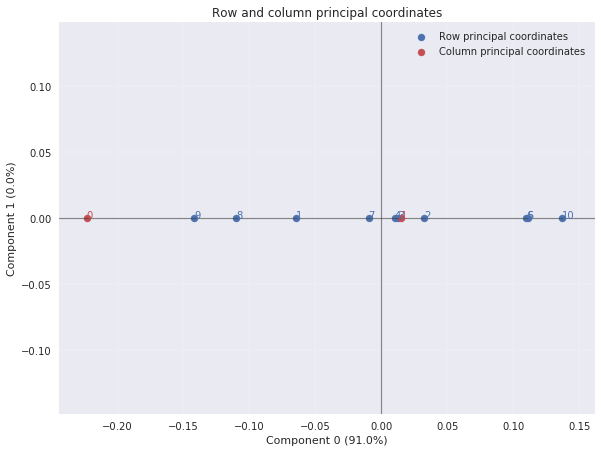

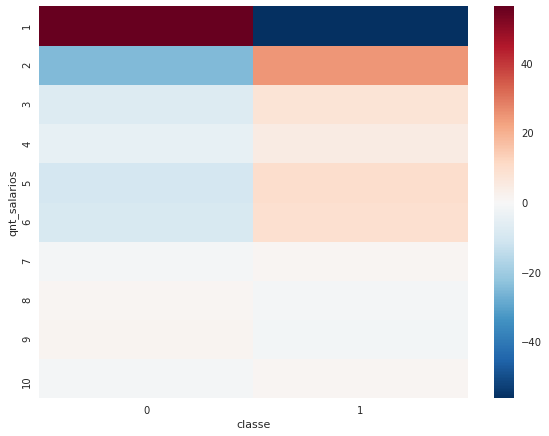

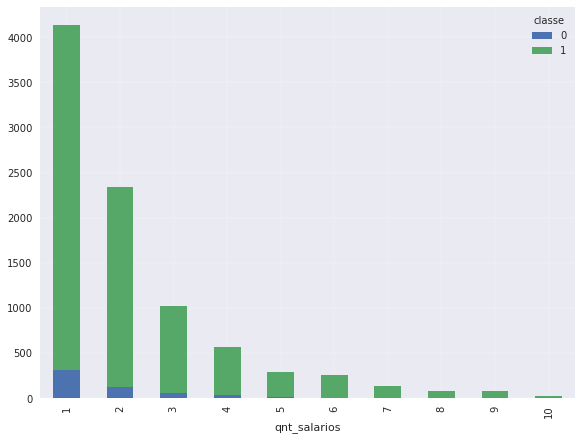

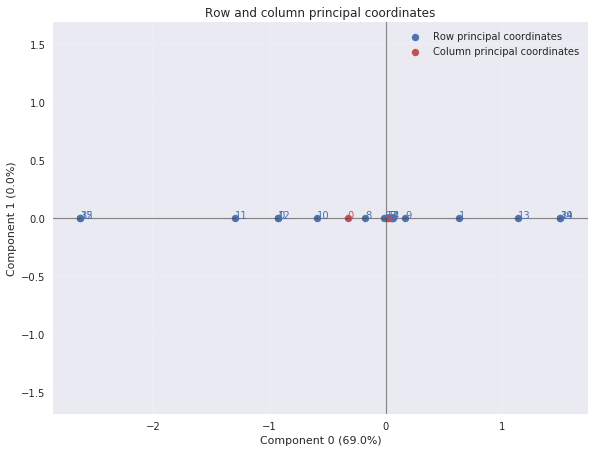

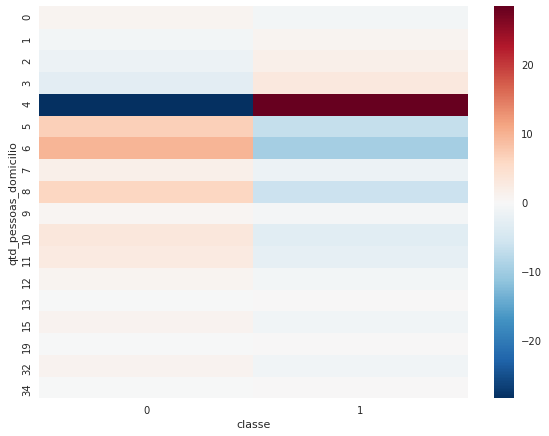

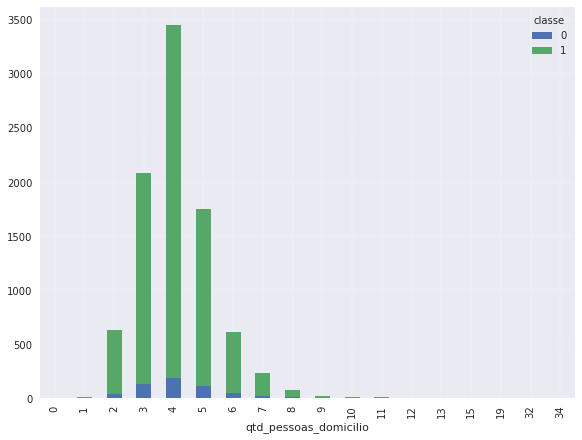

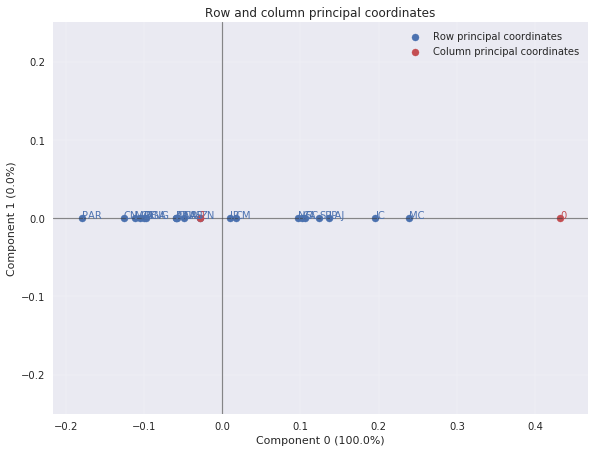

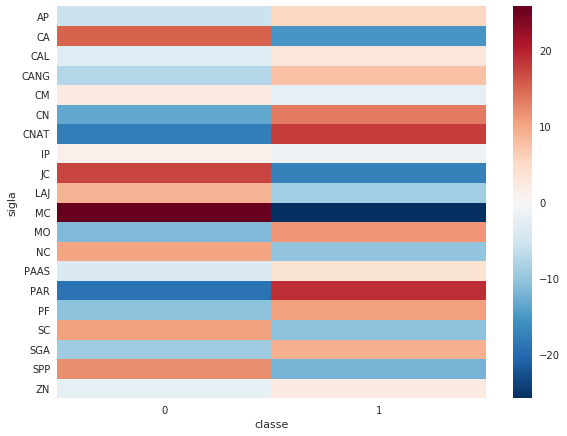

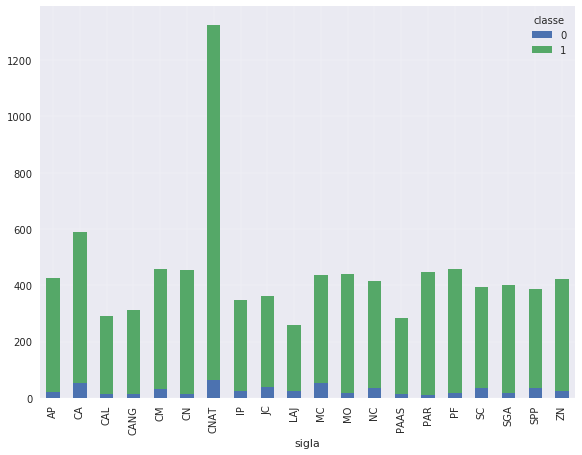

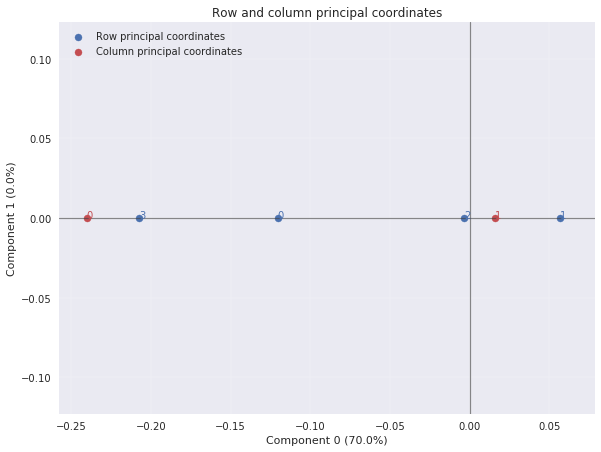

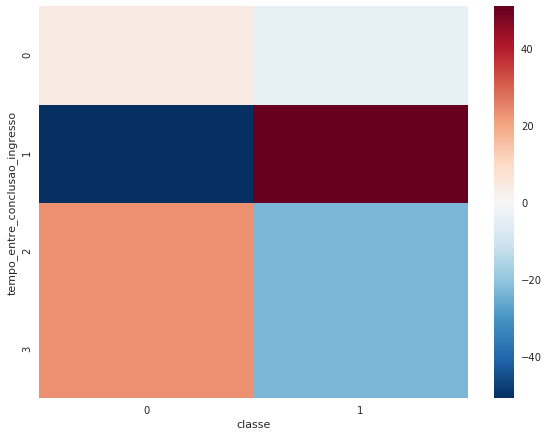

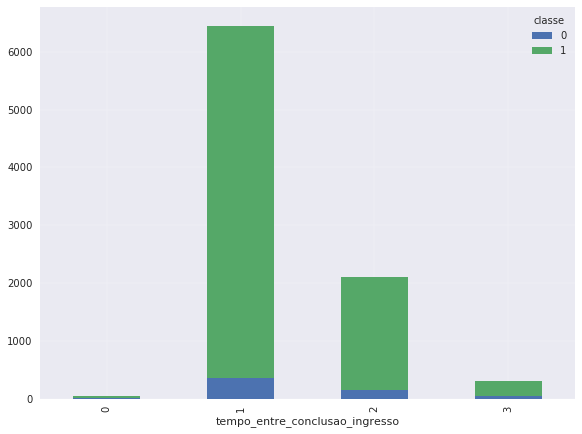

In [10]:
for index1 in dados.columns:
    #print(index1)
    if index1 in ['classe', 'id']:
        continue

    print(index1)
    print('-'*len(index1))        
        
    fig = plt.figure()
    #tabela de contigencia
    #tbl = pd.crosstab(index = dados[index1], columns = dados.classe, margins=True)
    tbl = pd.crosstab(index = dados[index1], columns = dados.classe)
    #print(tbl)

    #analise de correspondencia
    ca = prince.CA(tbl, n_components=-1)

    fig = plt.figure()
    fig, ax = ca.plot_rows_columns(axes=[0, 1], show_row_labels=True, show_column_labels=True)
    
    #ca.plot_cumulative_inertia()

    #matriz residual
    res = (ca.P - ca.expected_frequencies) * ca.N
    #res
       
    fig = plt.figure()
    sns.heatmap(res)
    
    fig = plt.figure()
    tbl.plot(kind="bar", stacked=True)    

# Análise de correspondência (livro Análise Multivariada de dados)

In [142]:
def calc_AC(tbl):
    df = tbl
    
    s1 = np.array(df.sum(axis=0))
    s2 = np.array(df.sum(axis=1))

    #somas
    #print(s1)
    #print(s2)
    
    #quantidade esperada nao normalizada
    mult_s = np.outer(s1[:, None], s2).T
    #print(mult_s)
    
    total_geral = df.sum().sum()
    #print(total_geral)    
    
    #quantidade esperada normalizada
    cont_esperada = mult_s/total_geral
    #print(cont_esperada)    
    
    #diferenca entre esperada e real
    diferenca = cont_esperada - df
    #print(diferenca)    
    
    #calculo qui-quadrado
    q2 = (diferenca*diferenca)/cont_esperada
    #print(q2)
    
    sinal = np.sign(diferenca) * -1
    #print(sinal)
    
    q2_sinal = q2 * sinal
    #print(q2_sinal)
    
    return q2_sinal

LnguaPortuguesaeLiteraturaI90H
------------------------------


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


LnguaPortuguesaeLiteraturaI90H_dependencia
------------------------------------------
LnguaPortuguesaeLiteraturaI90H_freq
-----------------------------------
MatemticaI120H
--------------


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


MatemticaI120H_dependencia
--------------------------
MatemticaI120H_freq
-------------------
acompanhamento
--------------
aluno_exclusivo_rede_publica
----------------------------
artificial
----------
conceito
--------
conceito_freq
-------------
descricao
---------
descricao_area_residencial
--------------------------
descricao_companhia_domiciliar
------------------------------
descricao_estado_civil
----------------------
descricao_historico
-------------------
descricao_imovel
----------------
descricao_mae_escolaridade
--------------------------
descricao_pai_escolaridade
--------------------------
descricao_raca
--------------
descricao_responsavel_escolaridade
----------------------------------
descricao_responsavel_financeiro
--------------------------------
descricao_trabalho
------------------
idade
-----
pessoa_fisica__sexo
-------------------
possui_necessidade_especial
---------------------------
qnt_pc
------
qnt_salarios
------------
qtd_pessoas_domicilio
------------

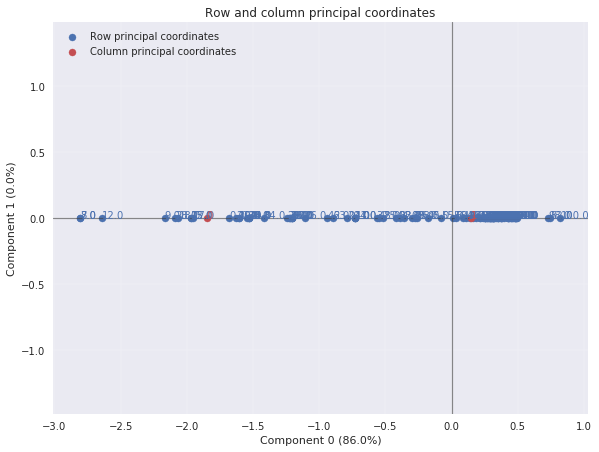

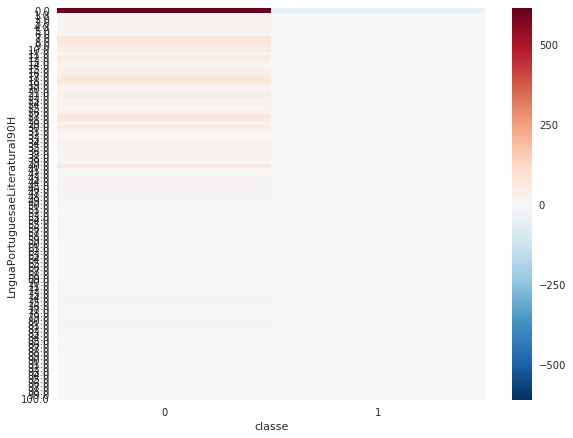

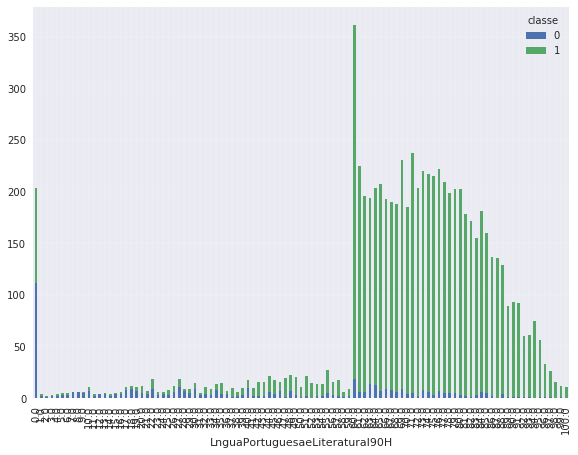

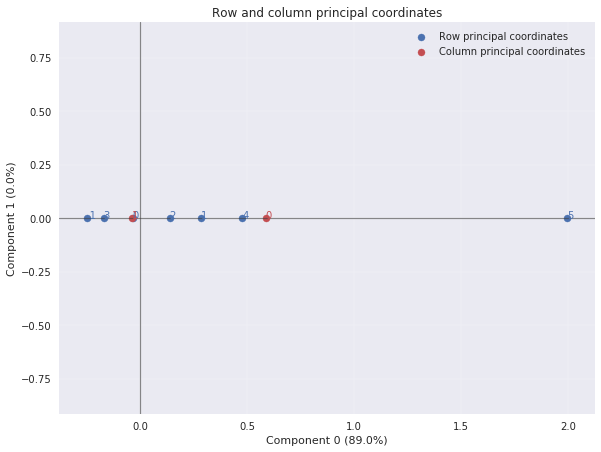

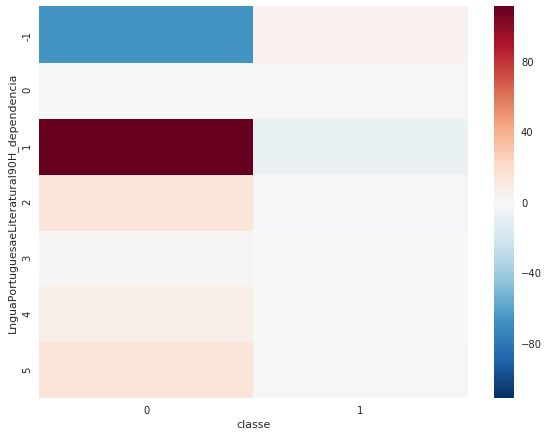

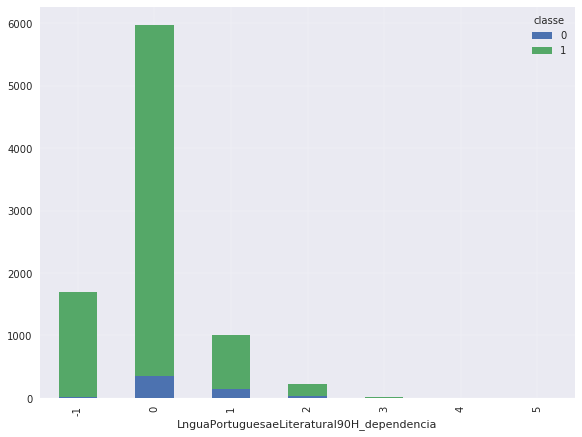

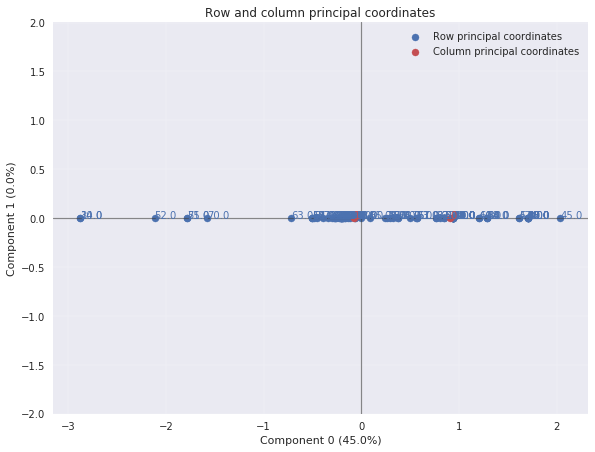

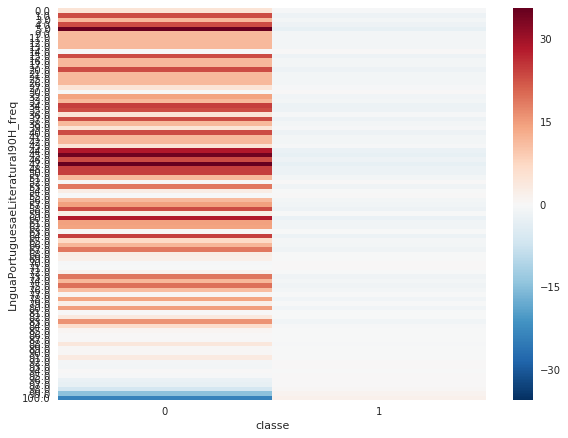

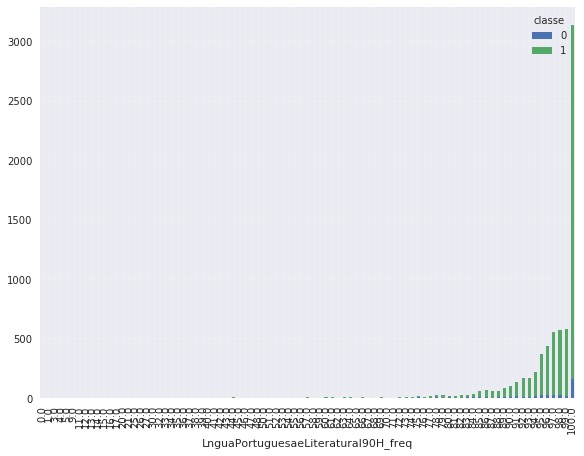

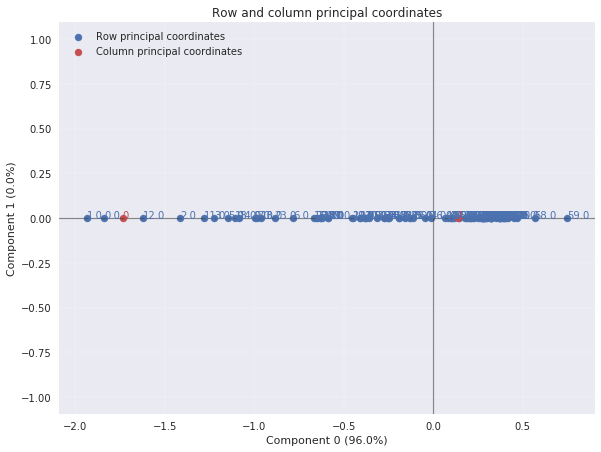

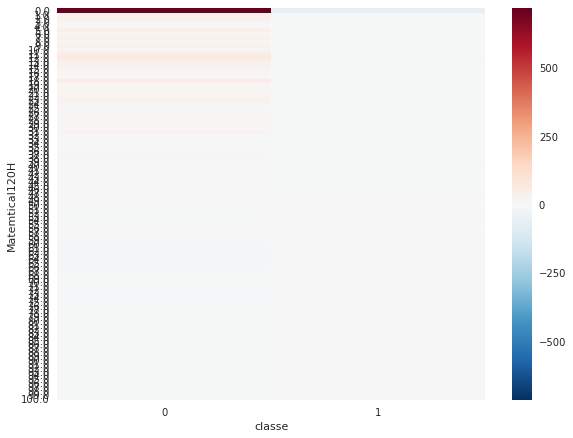

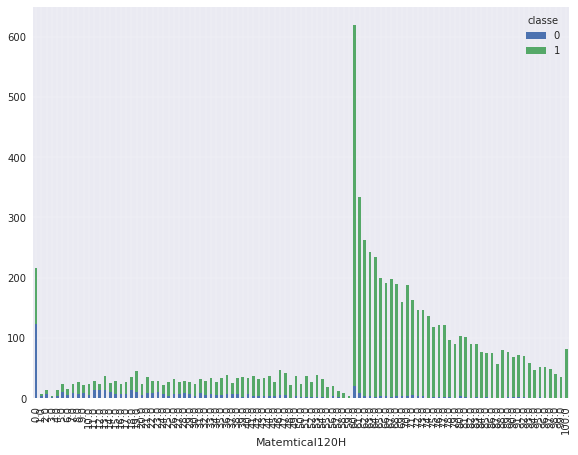

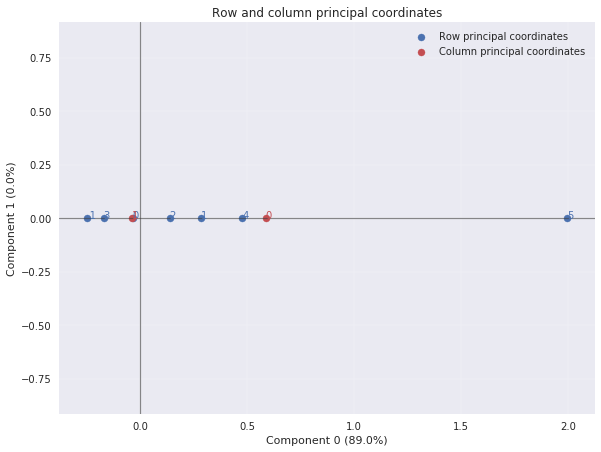

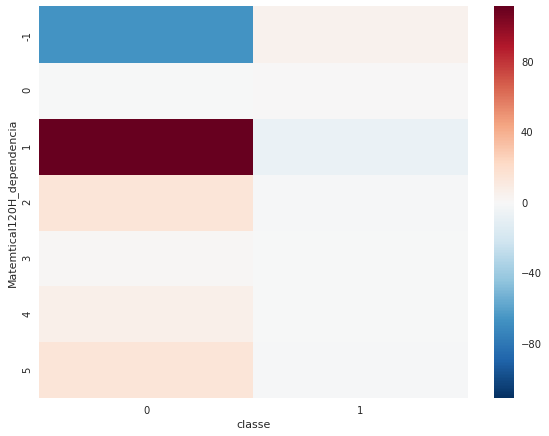

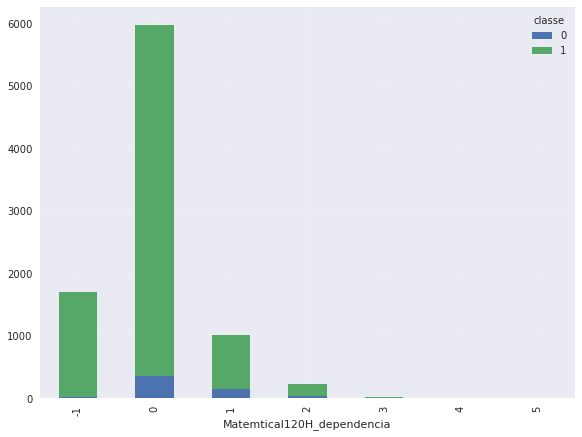

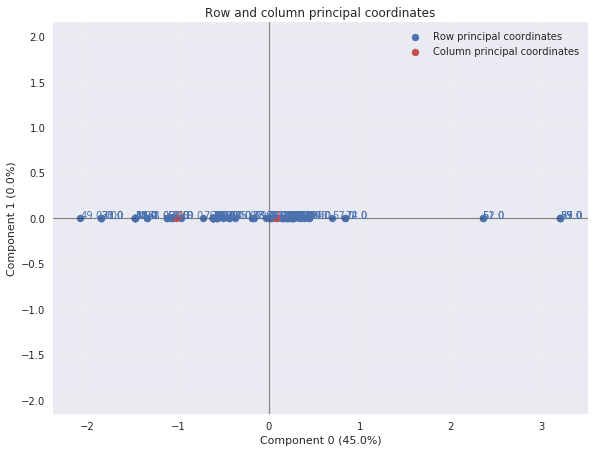

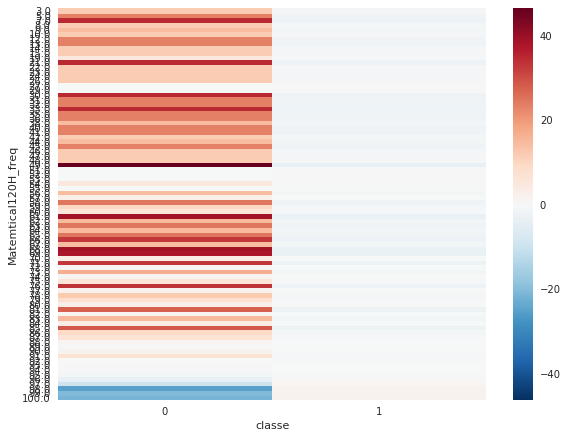

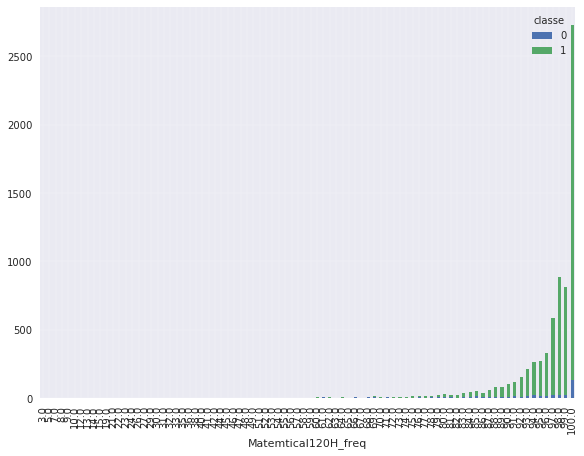

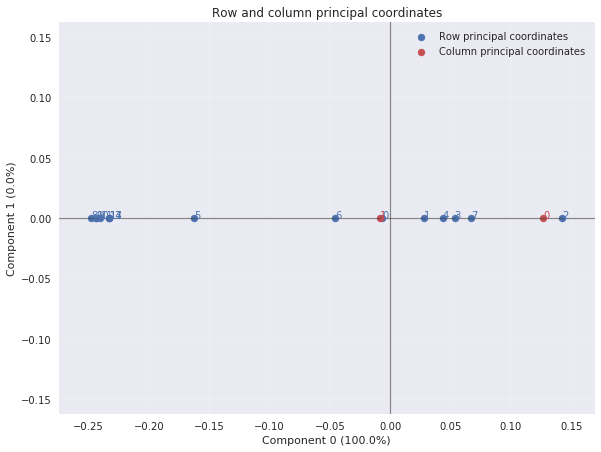

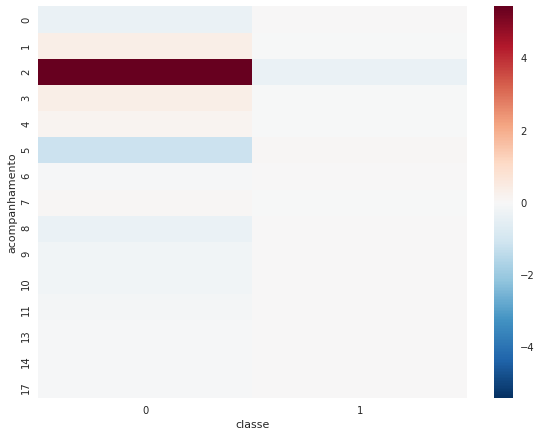

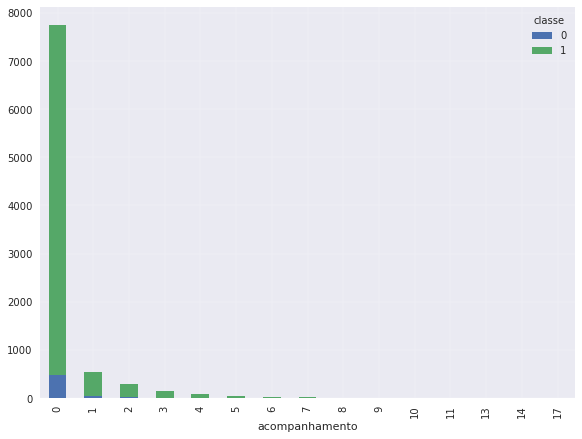

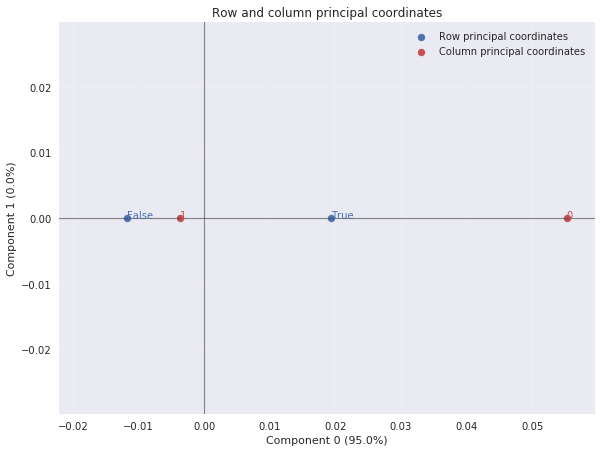

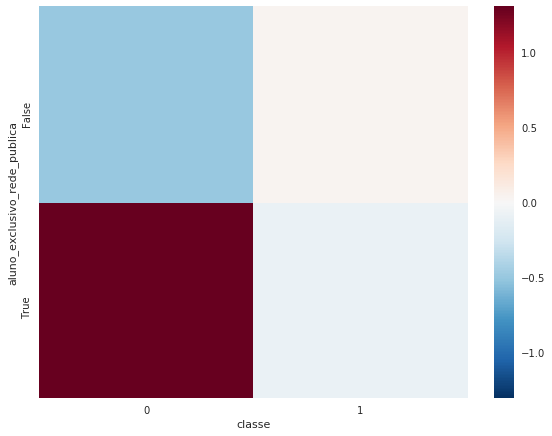

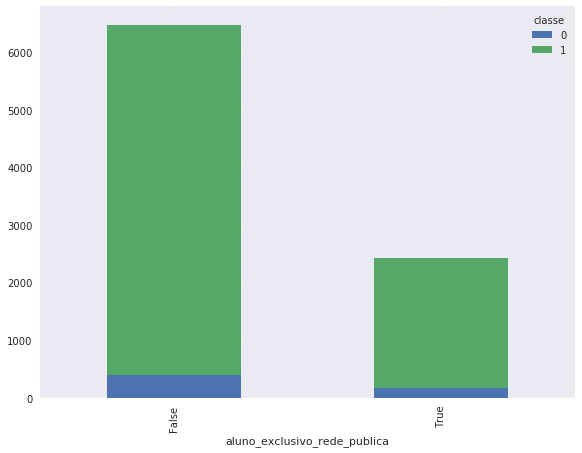

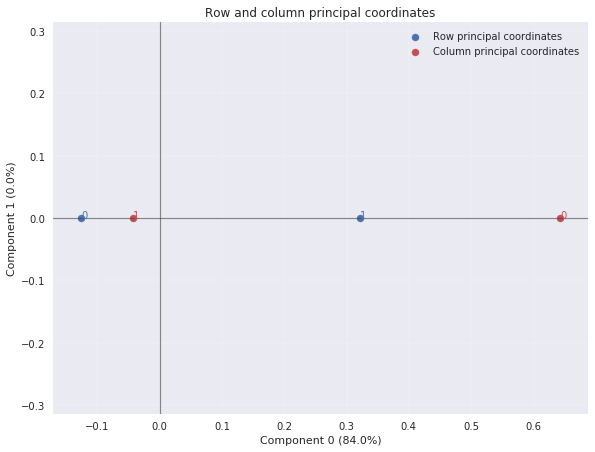

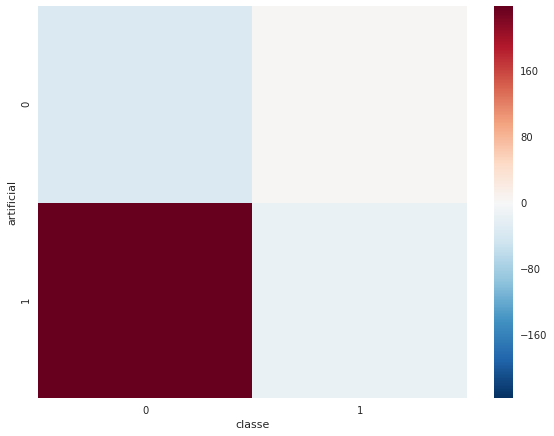

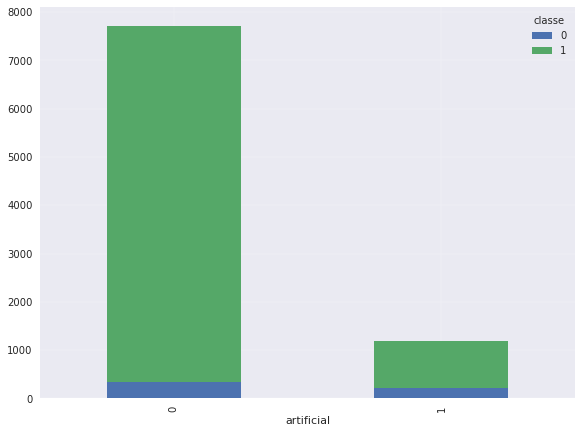

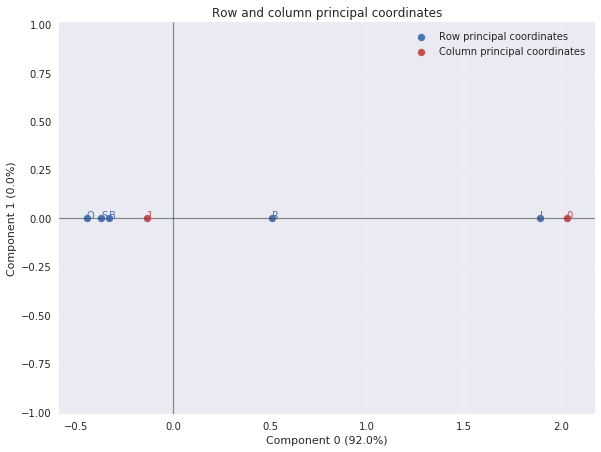

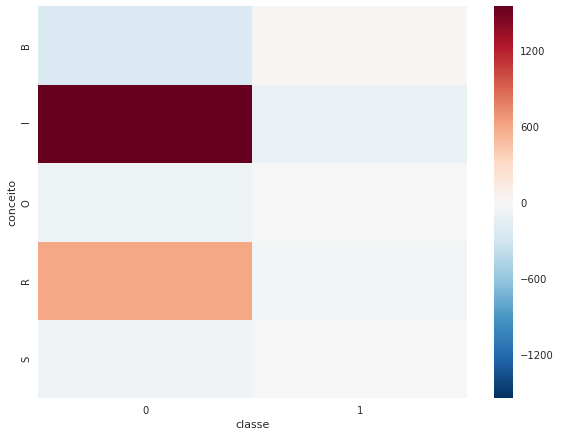

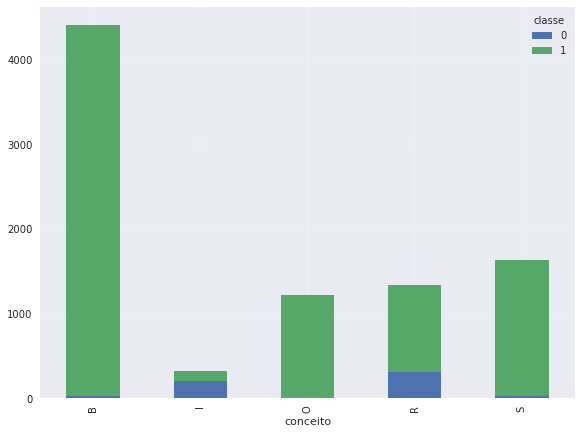

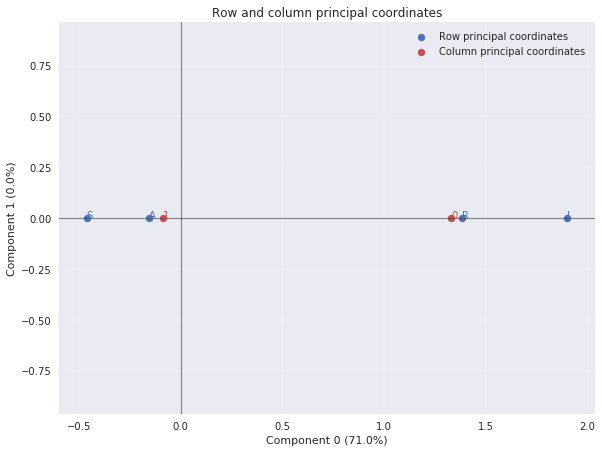

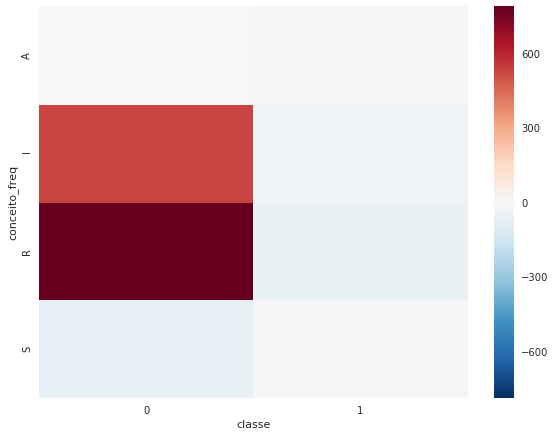

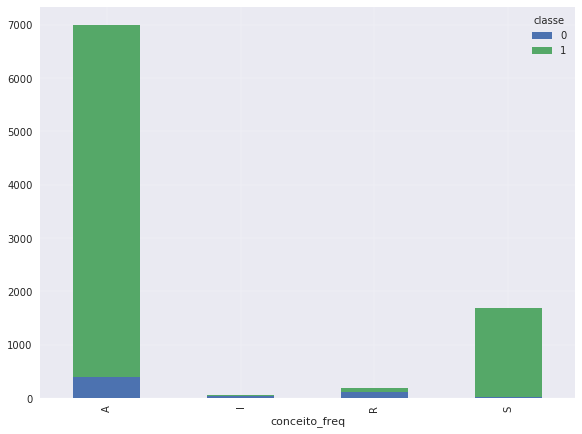

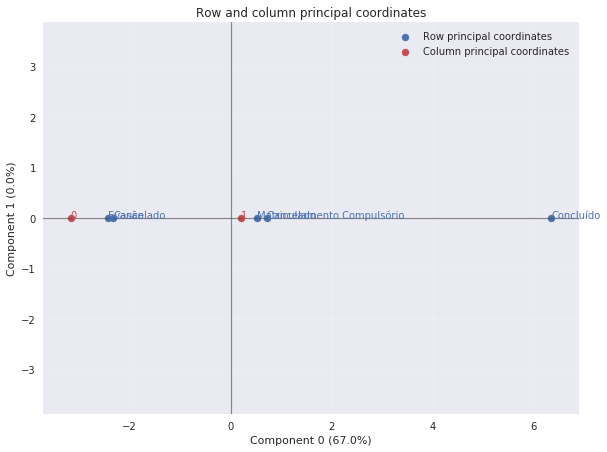

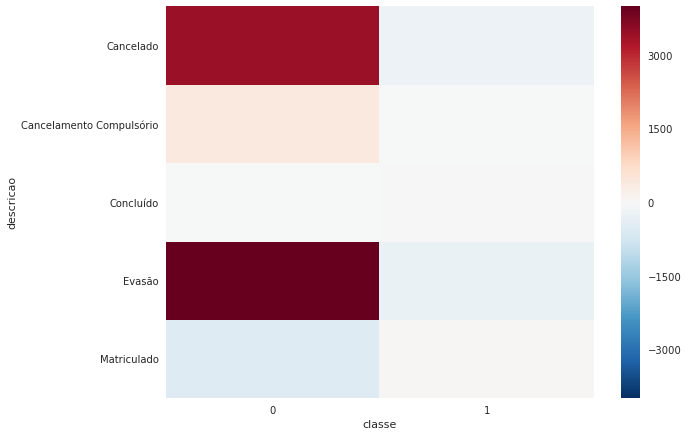

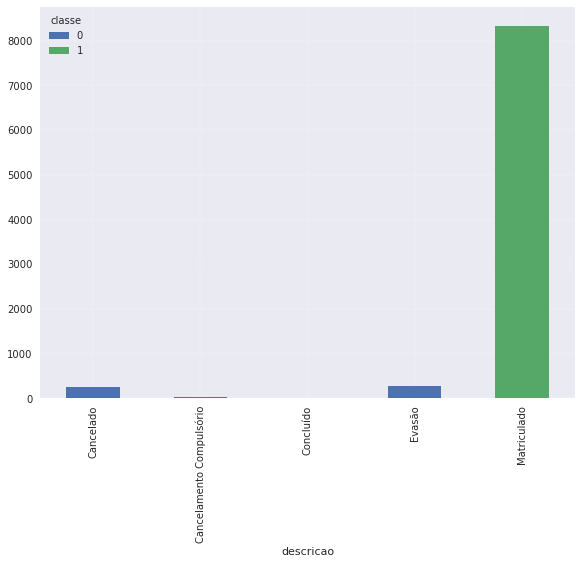

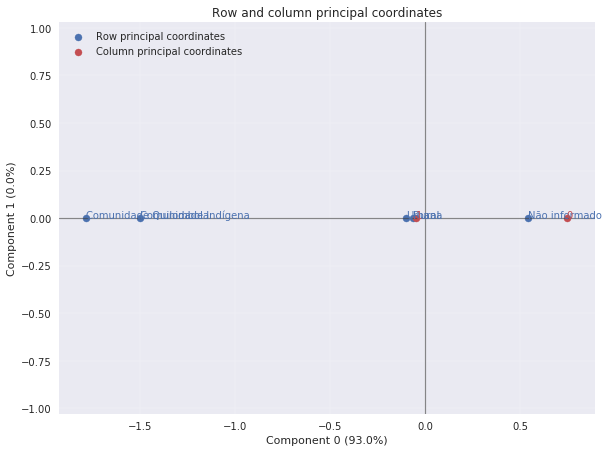

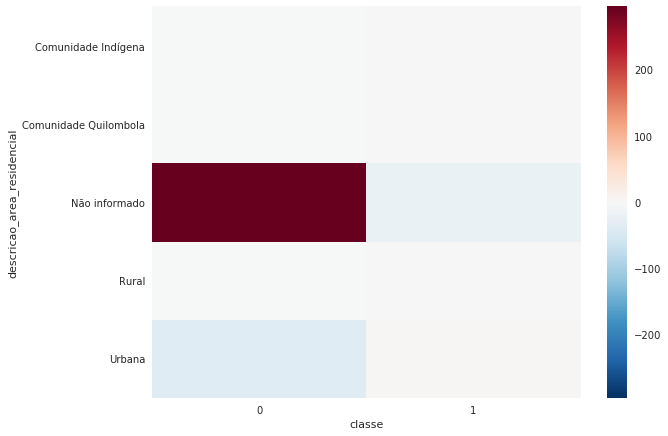

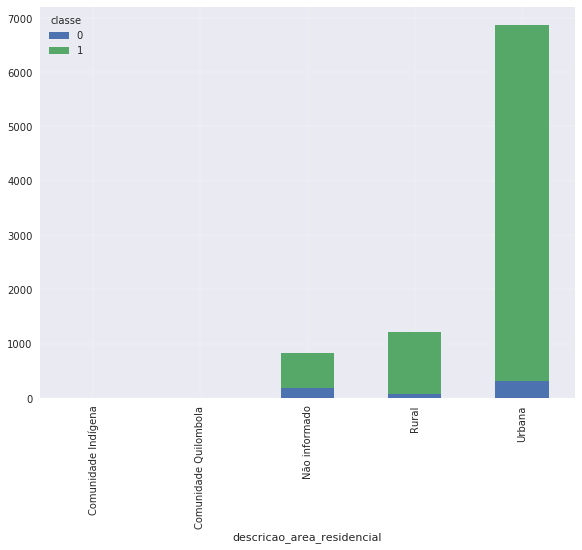

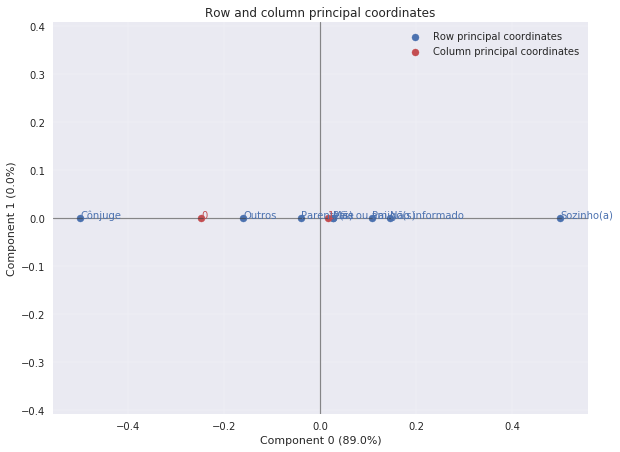

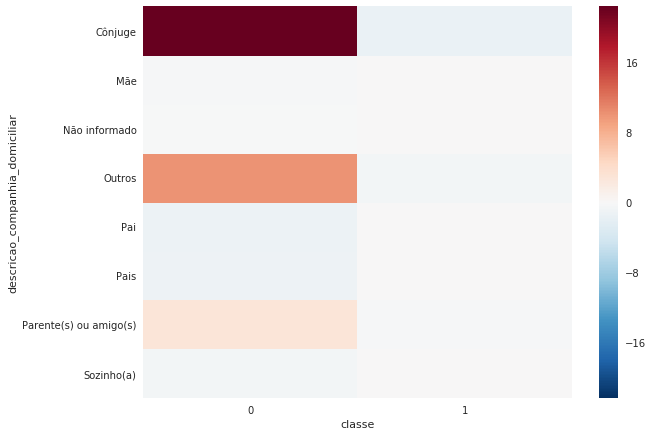

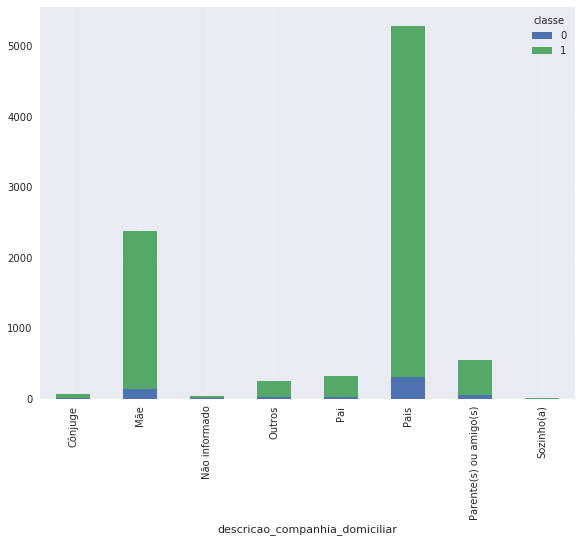

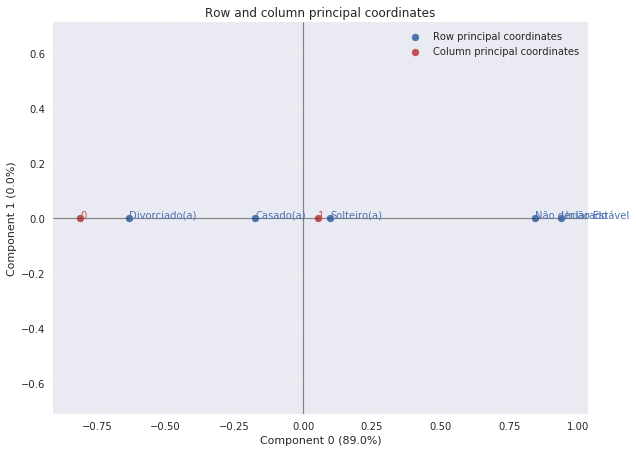

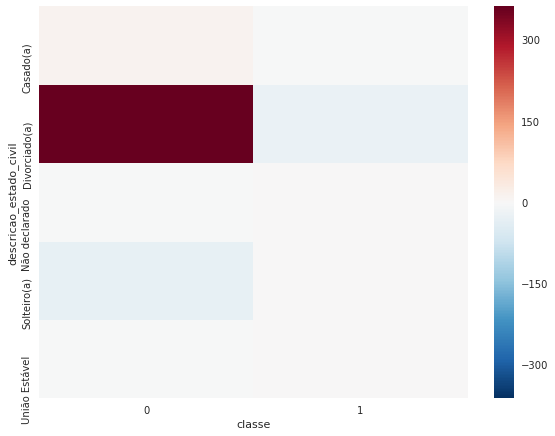

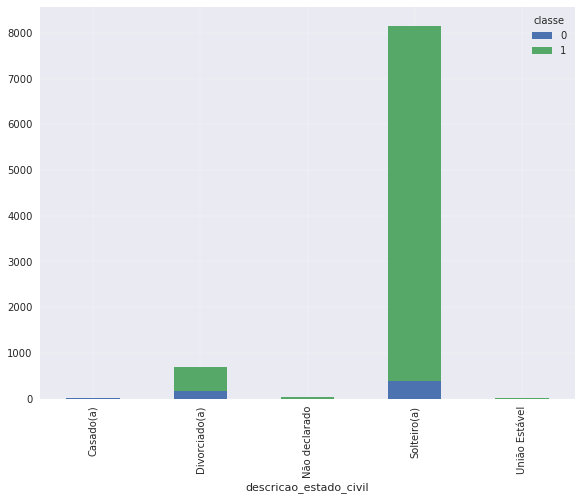

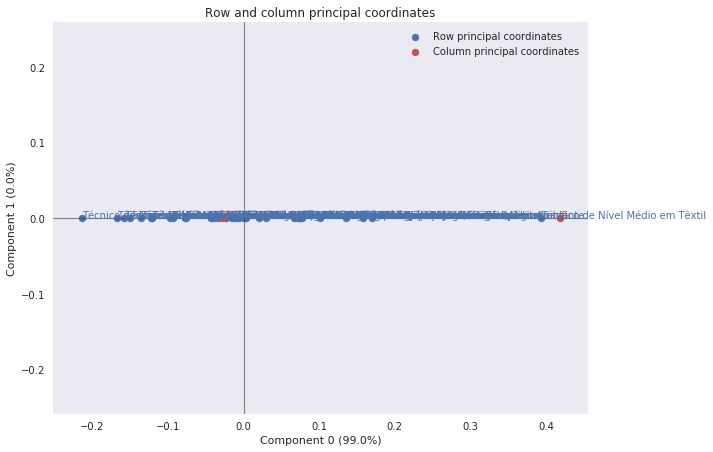

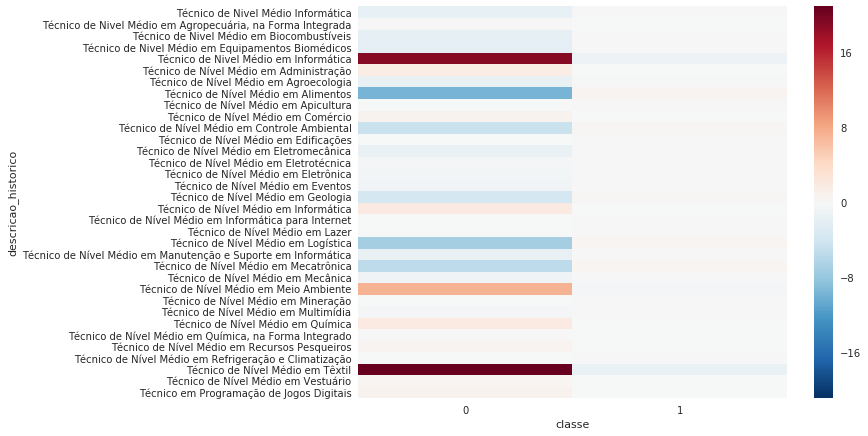

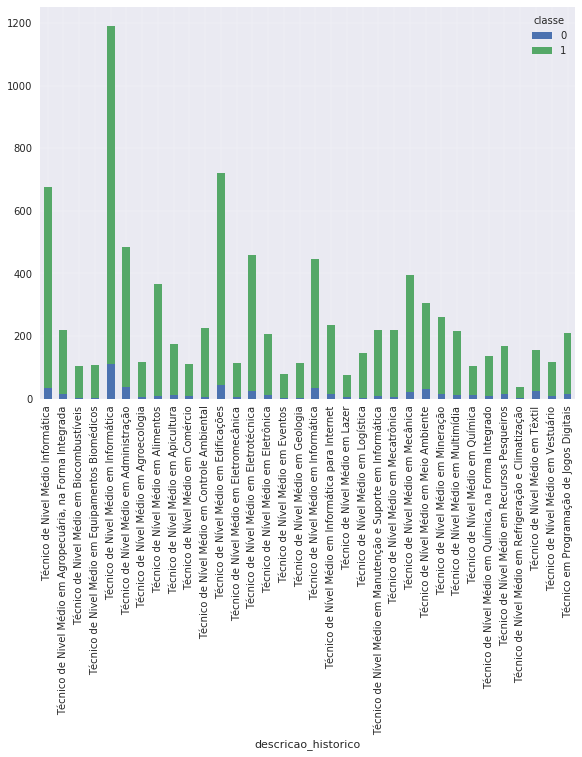

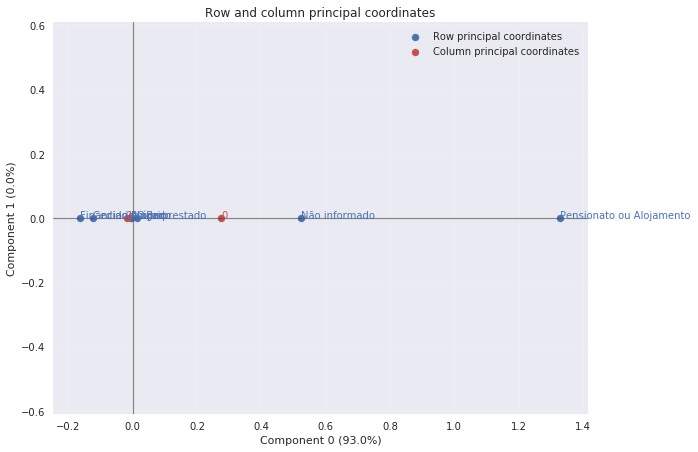

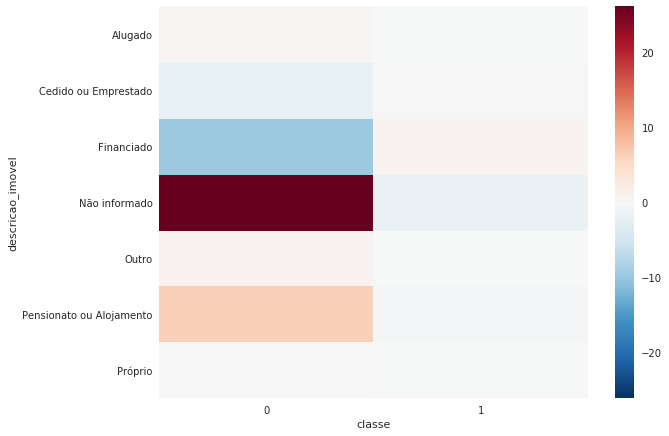

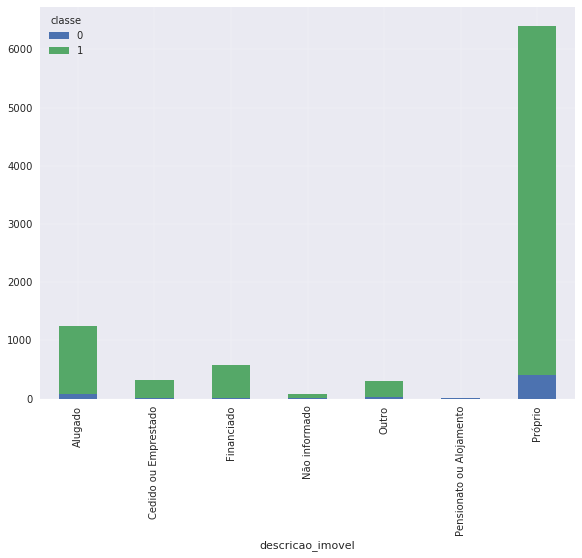

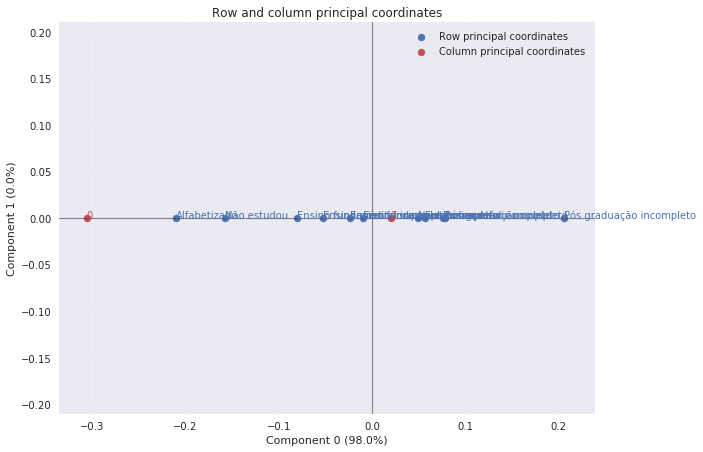

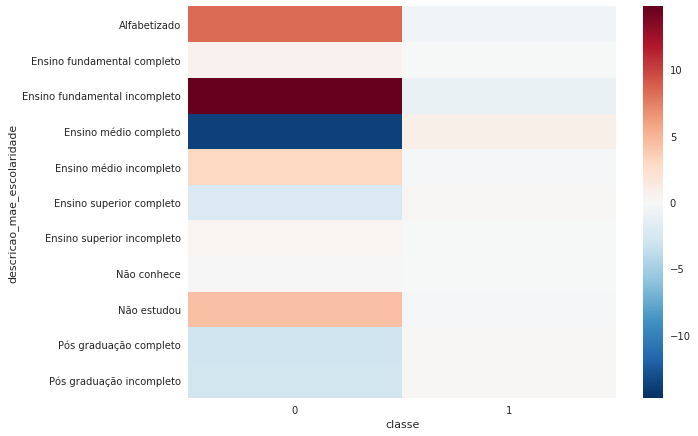

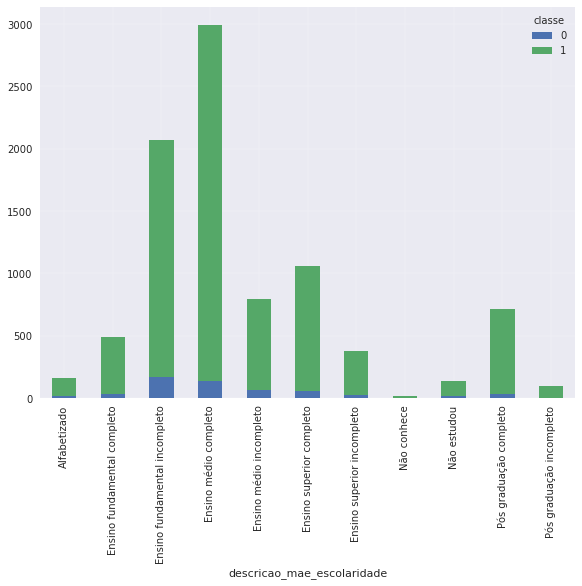

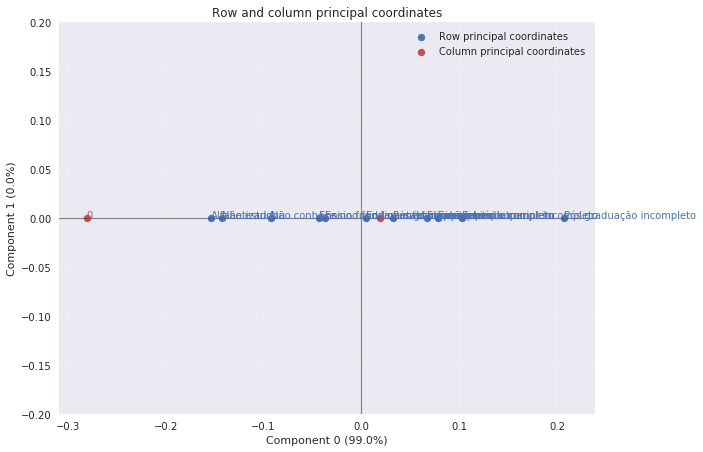

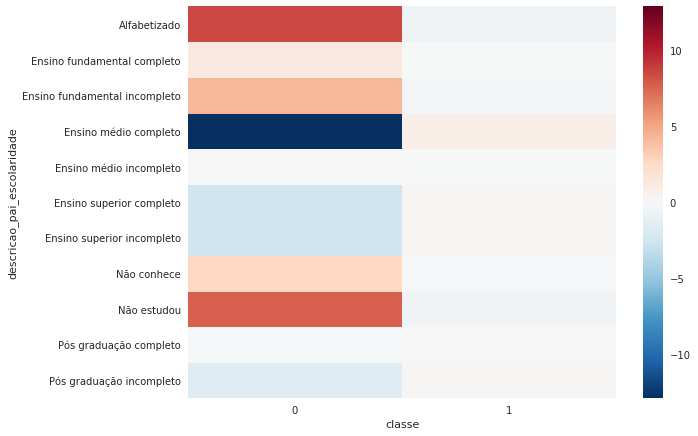

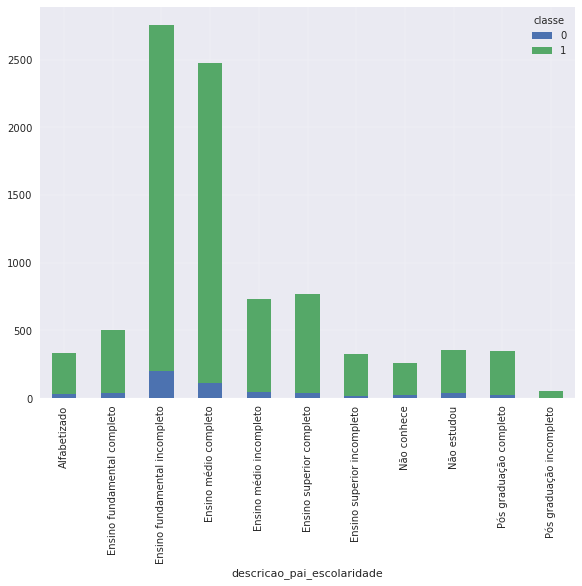

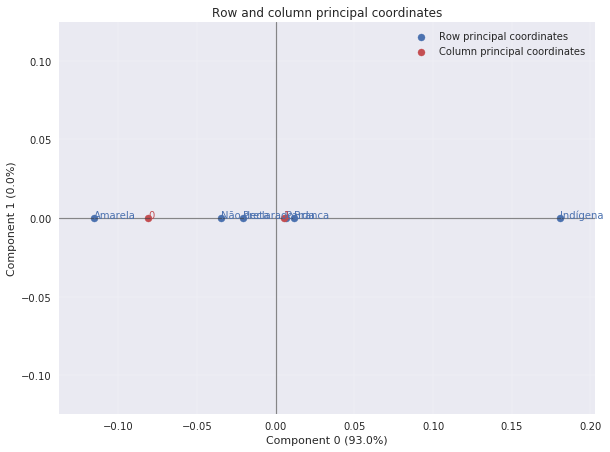

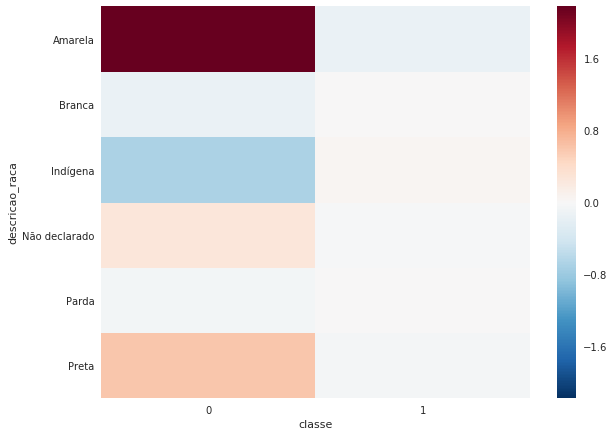

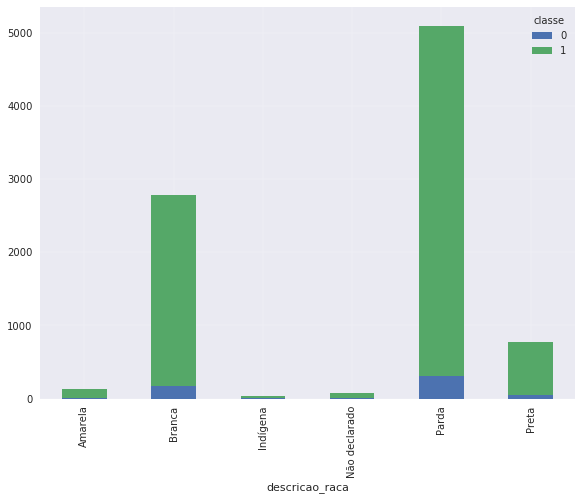

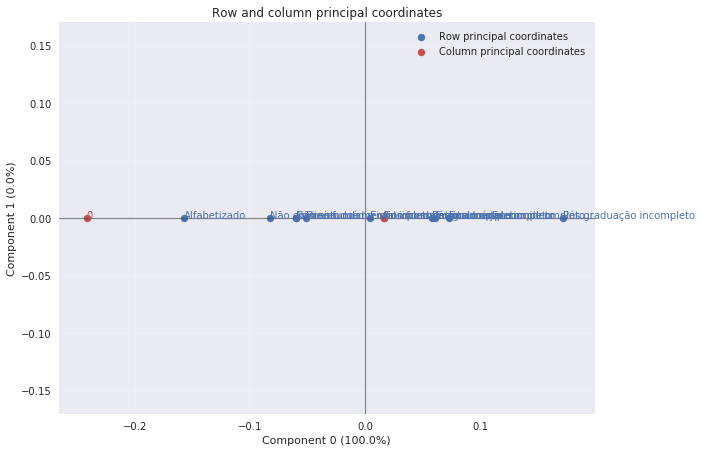

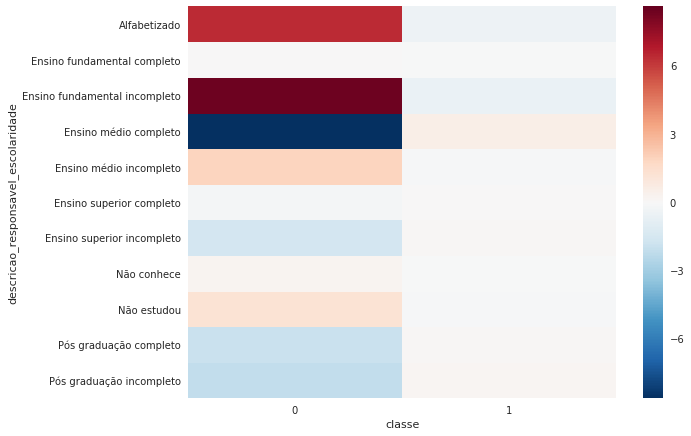

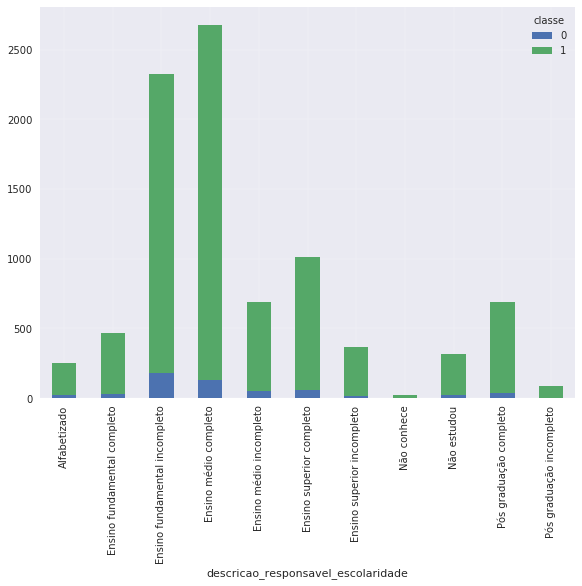

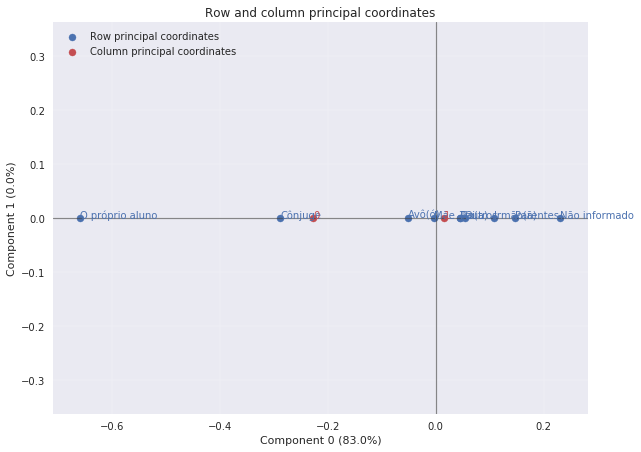

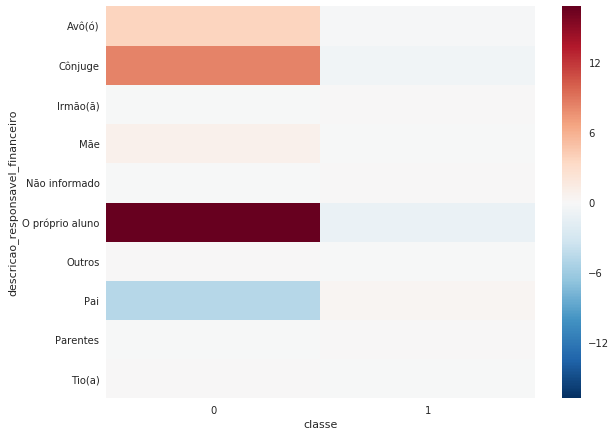

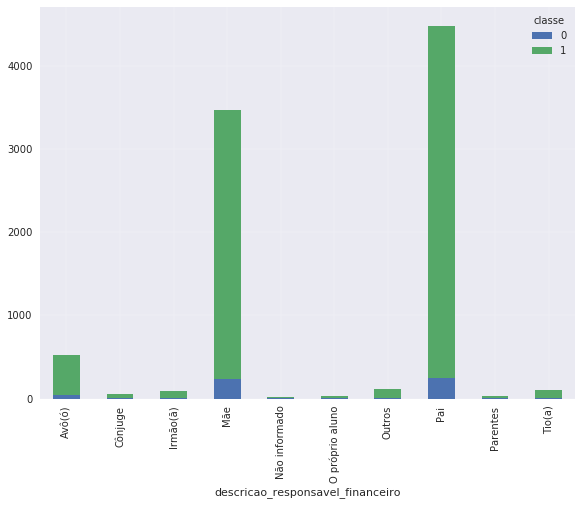

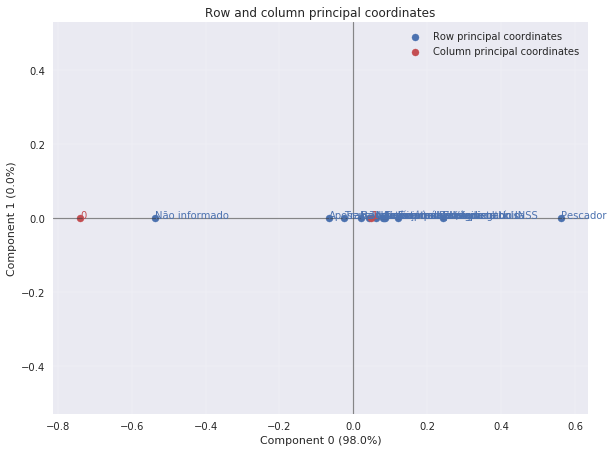

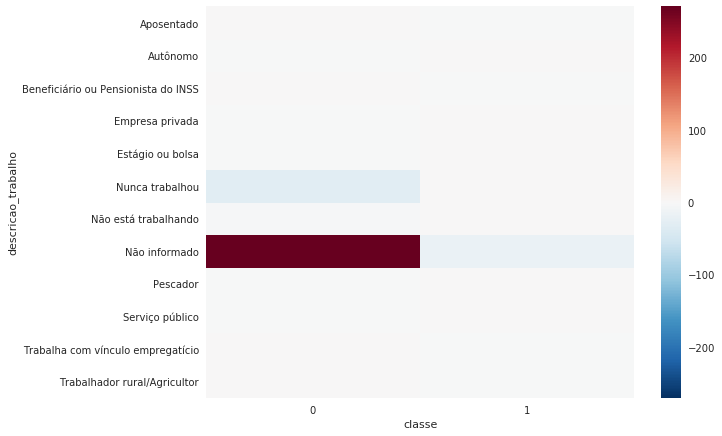

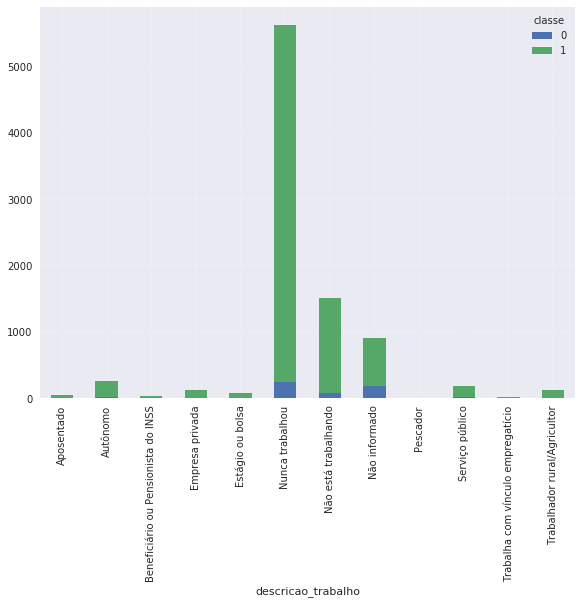

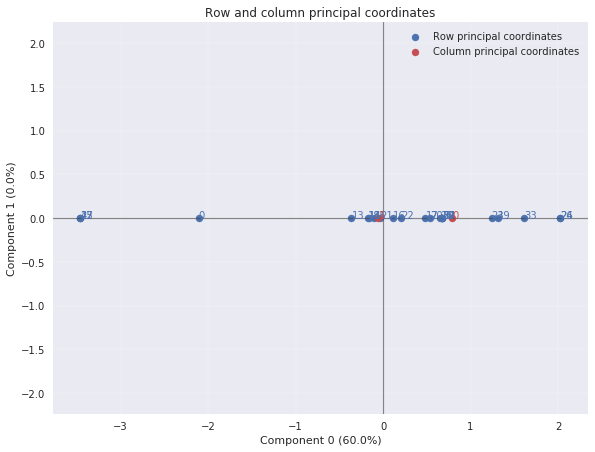

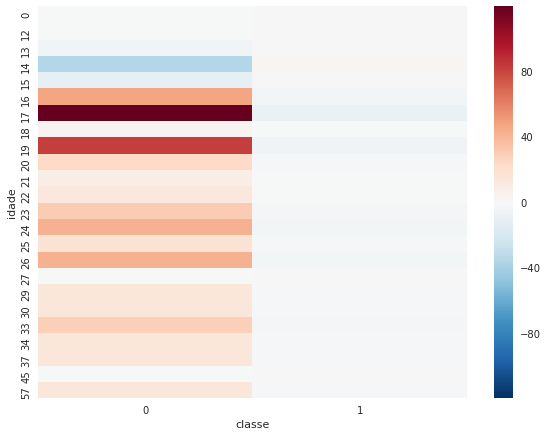

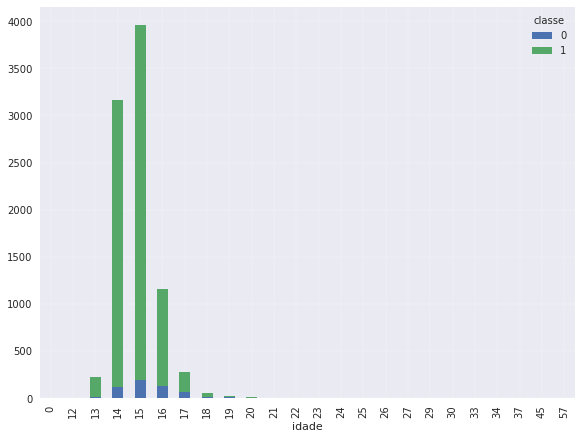

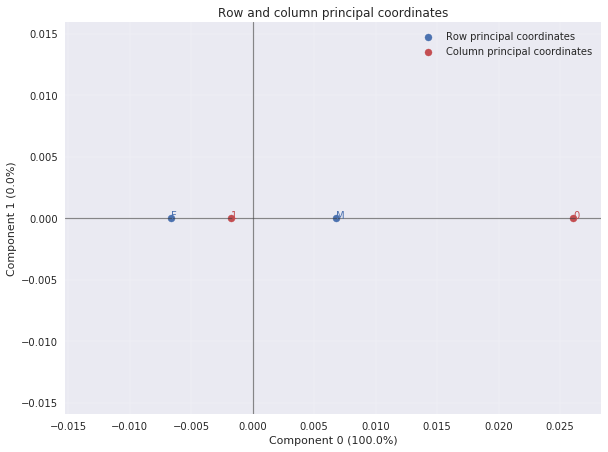

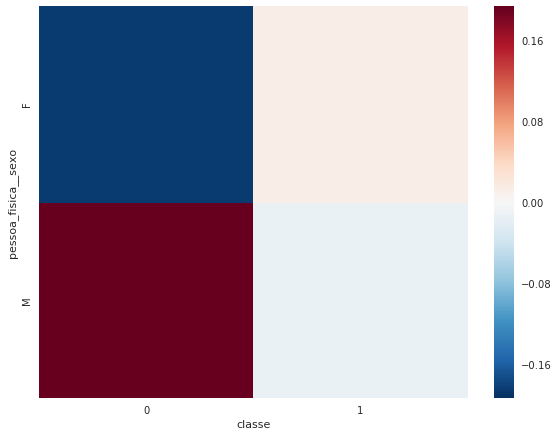

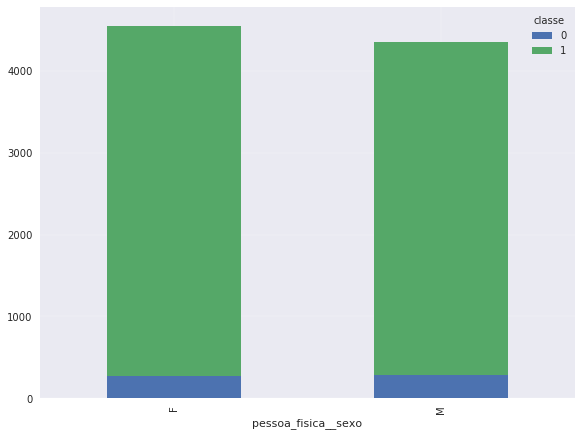

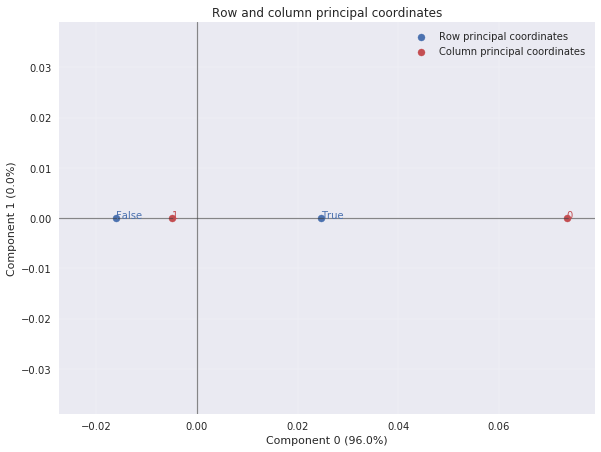

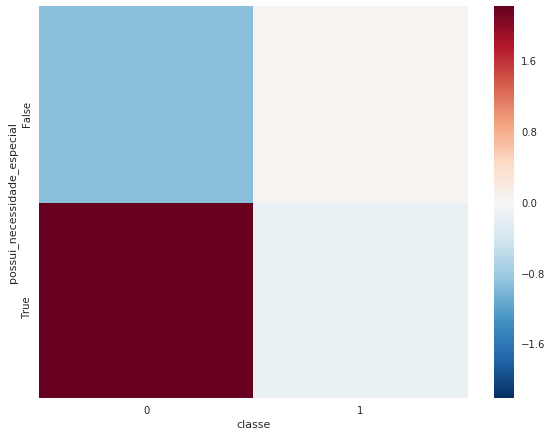

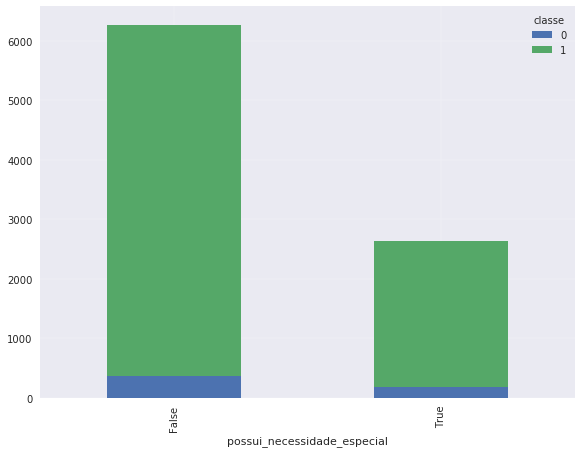

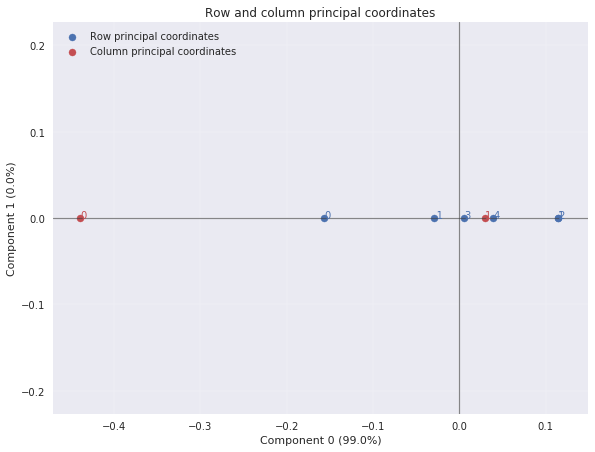

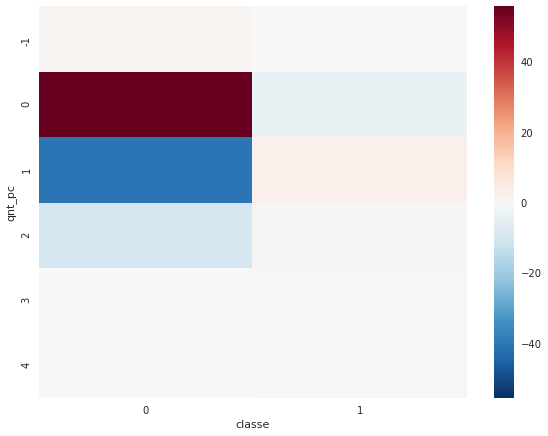

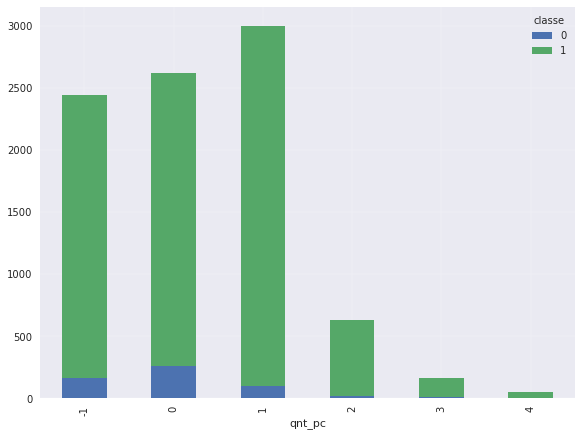

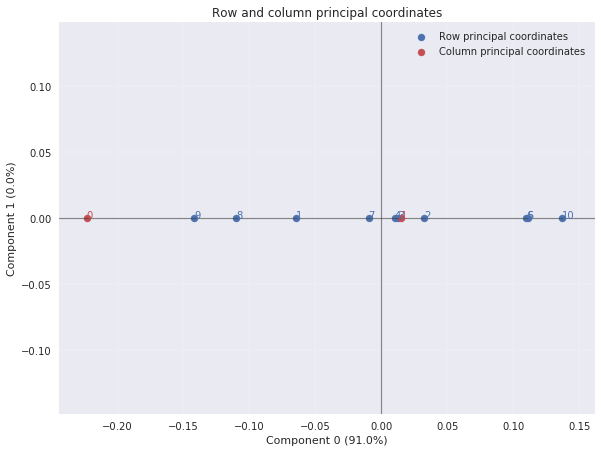

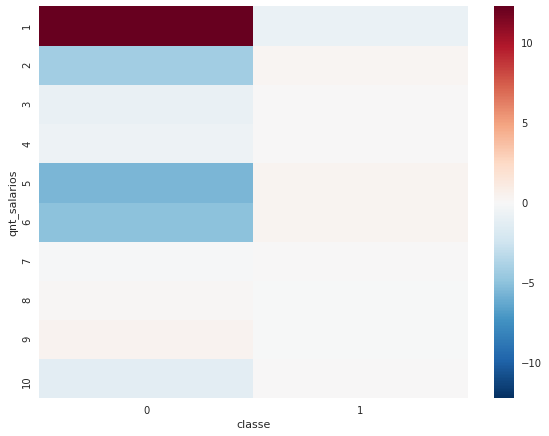

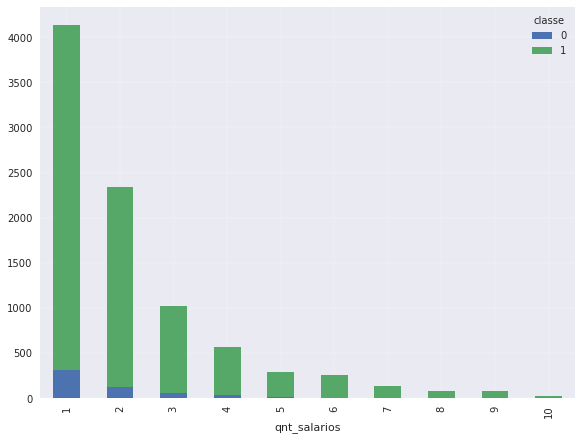

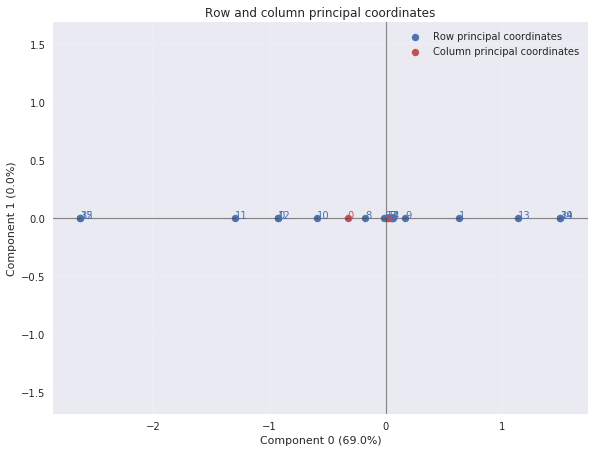

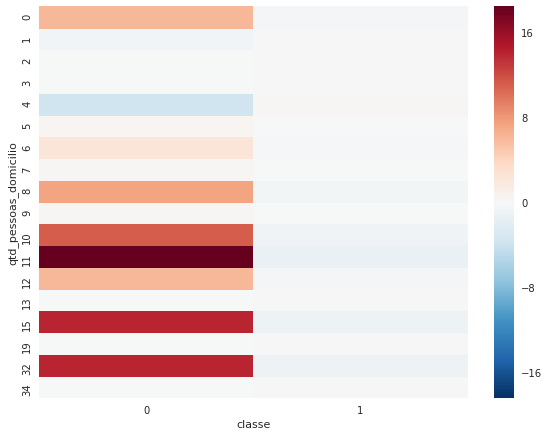

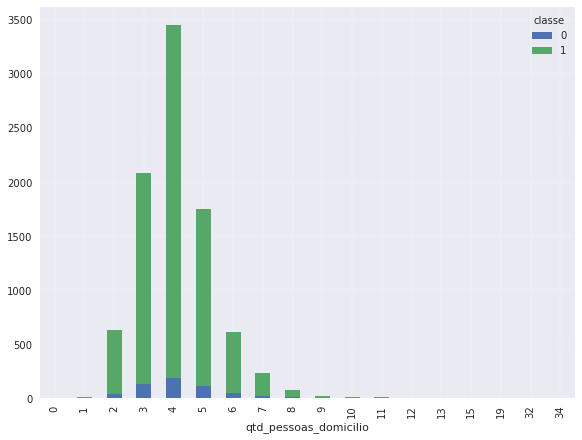

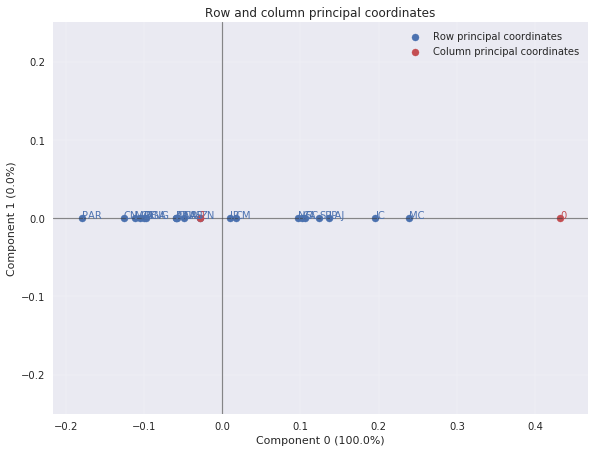

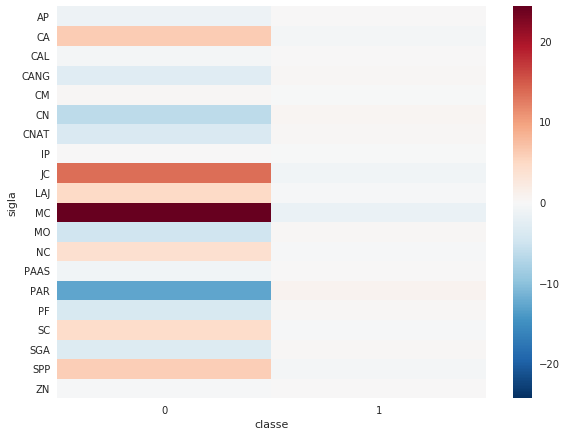

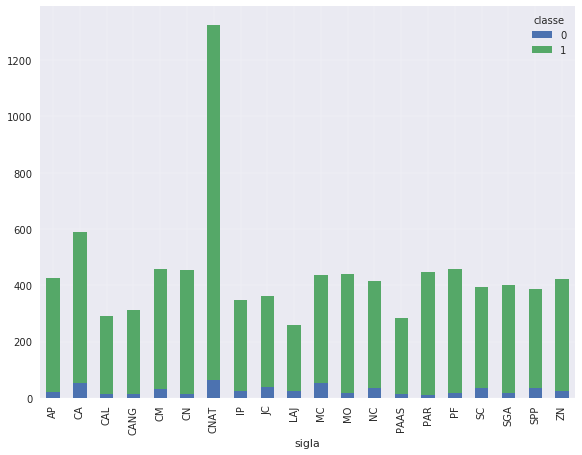

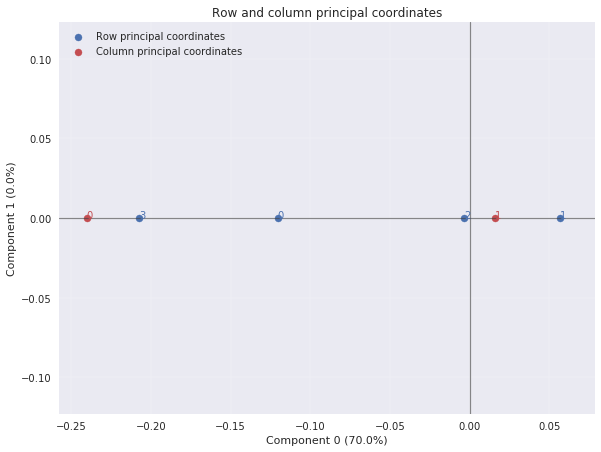

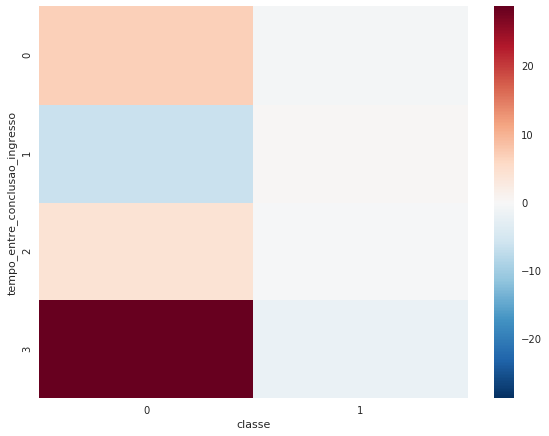

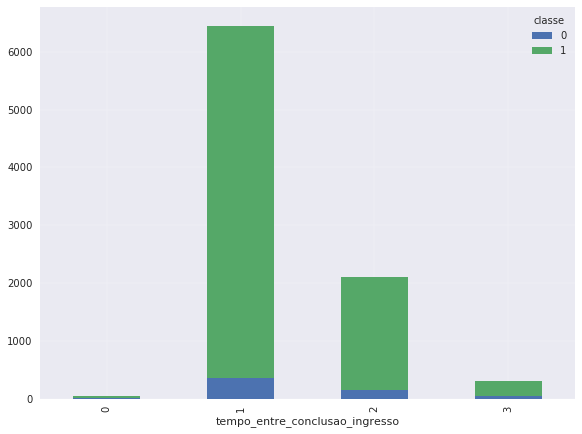

In [152]:
for index1 in dados.columns:
    
    #print(index1)
    if index1 in ['classe', 'id']:
        continue

    print(index1)
    print('-'*len(index1))        
        
    fig = plt.figure()
    #tabela de contigencia
    #tbl = pd.crosstab(index = dados[index1], columns = dados.classe, margins=True)
    tbl = pd.crosstab(index = dados[index1], columns = dados.classe)
    #print(tbl)

    #analise de correspondencia
    ca = prince.CA(tbl, n_components=-1)

    fig = plt.figure()
    fig, ax = ca.plot_rows_columns(axes=[0, 1], show_row_labels=True, show_column_labels=True)
    
    #matriz residual
    res = calc_AC(tbl)
       
    fig = plt.figure()
    sns.heatmap(res)
    
    fig = plt.figure()
    tbl.plot(kind="bar", stacked=True)   


# TESTES

A   B   C
18-35  20  20  20
36-55  40  10  40
56>    20  10  40

In [136]:
q2 = calc_AC(df)
q2

A         B         C
18-35 -0.151515  7.575758 -1.939394
36-55  1.616162 -2.474747 -0.020202
56>   -1.168831 -0.584416  2.103896

In [139]:
tbl = pd.crosstab(index = dados.descricao_mae_escolaridade, columns = dados.classe)
q2 = calc_AC(tbl)
q2

classe                                 0         1
descricao_mae_escolaridade                        
Alfabetizado                    8.300159 -0.552549
Ensino fundamental completo     0.657196 -0.043750
Ensino fundamental incompleto  14.749271 -0.981872
Ensino médio completo         -13.732021  0.914153
Ensino médio incompleto         3.018878 -0.200969
Ensino superior completo       -2.214425  0.147416
Ensino superior incompleto      0.245529 -0.016345
Não conhece                     0.018220 -0.001213
Não estudou                     4.487185 -0.298716
Pós graduação completo         -2.944975  0.196050
Pós graduação incompleto       -2.770691  0.184447

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


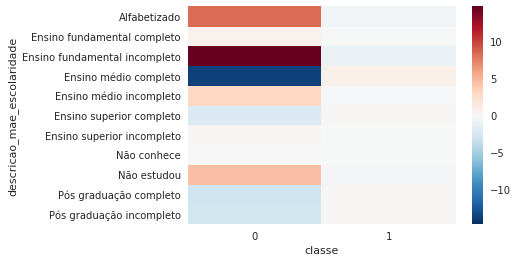

In [140]:
sns.heatmap(q2)